In [ ]:
# Treinar o modelo LM pre-treinado nas Sentenças nas Tarefas de NLP especifica (NER) usando Adapters.
# https://github.com/piegu/language-models/blob/master/adapters/language-modeling/language_modeling_adapter.ipynb
# https://github.com/piegu/language-models/blob/master/adapters/token-classification/token_classification_adapter.ipynb
# https://huggingface.co/course/chapter7/2?fw=pt
# https://huggingface.co/course/chapter7/3?fw=pt

In [1]:
import pathlib
from pathlib import Path
import pickle
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from colorama import Fore, Back, Style
import random
from IPython.display import display, HTML


import sys; print('python:',sys.version)
import torch; print('Pytorch:',torch.__version__)
import transformers; print('adapter-transformers:',transformers.__version__)
#import transformers; print('HF transformers:',transformers.__hf_version__)     # <======
import tokenizers; print('tokenizers:',tokenizers.__version__)

import datasets; print('datasets:',datasets.__version__)
from datasets import DatasetDict, Dataset, ClassLabel, Sequence
from datasets import load_dataset, load_metric
from datasets import Value 

from transformers.adapters.composition import Stack
from transformers.trainer_callback import EarlyStoppingCallback
from transformers import AdapterConfig
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification, AutoTokenizer, TrainingArguments, Trainer
from transformers import AutoTokenizer 

import torch
from torch.nn import CrossEntropyLoss
from torch.nn import ModuleDict

#!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu

python: 3.8.13 (default, Mar 28 2022, 11:38:47) 
[GCC 7.5.0]
Pytorch: 1.12.0+cpu


2022-08-05 01:41:22.921969: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-05 01:41:22.921982: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/info/.conda/envs/acptrt1/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


adapter-transformers: 4.17.0
tokenizers: 0.12.1
datasets: 1.11.0


In [2]:
#root path ==================================================
# root = Path.cwd()
model_checkpoint = "/home/info/MyNotebooks/bert-base-portuguese-cased-finetuned-ACP/checkpoint-1500/"

root = Path("/home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP")
root = Path(root)
root


# DATASET ==================================================
#
# LeNER-br in Portuguese
dataset_name = "LeNER-Br"
dataset_file = "/home/info/MyNotebooks/Datasets/LeNER-Br/LeNER-Br/"


# train BERT with 2 sentences consecutive ==================================================
next_sentence = True

task = "ner"


# Main hyperparameters
# training arguments ==================================================
batch_size = 8
gradient_accumulation_steps = 1

learning_rate = 1e-4
num_train_epochs = 3 # 20.
early_stopping_patience = 5

adam_epsilon = 1e-6

fp16 = True
ds = False # If True, we use DeepSpeed

# best model
load_best_model_at_end = True 
metric_for_best_model = "f1"
greater_is_better = True

# weighted loss
weighted_loss = True #False
if weighted_loss:
    c = 0.3
else:
    c = 0.0


    
# train adapter ==================================================
train_adapter = True # we want to train an adapter
load_adapter = None # we do not upload an existing adapter 

# lang adapter ==================================================
with_adapters_mlm = False #True # if False, we do not upload an existing lang adapter

if with_adapters_mlm:
    # define values to upload a specific lang adapter
    adapter_composition = "stack" # we will stack the lang and task adapters
else:
    adapter_composition = None

# if True, do not put adapter in the last transformer layer (Pfeiffer configuration)
madx2 = True

# if True, do not put adapter in the last transformer layer after the FeedFordarw block (Houlsby configuration)
houlsby_MHA_lastlayer = False


# Configuration ==================================================
os.environ["WANDB_DISABLED"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['KMP_DUPLICATE_LIB_OK']='True'

torch.cuda.is_available = lambda : False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device



## Adapters config
# Task adapter config ==================================================

adapter_config_name = "pfeiffer" # houlsby is possible, too
if adapter_config_name == "pfeiffer":
    adapter_non_linearity = 'gelu' # relu is possible, too
elif adapter_config_name == "houlsby":
    adapter_non_linearity = 'swish'
adapter_reduction_factor = 16
language = 'pt' # pt = Portuguese

adapter_config_name, adapter_non_linearity, adapter_reduction_factor, language


# Lang adapter config  ==================================================
if with_adapters_mlm:
    # AQUI PODE ESTAR O PROBLEMA! Mas todos hiperparametros referem-se ao _mlm!
    #
    # hyperparameters used for fine-tuning the MLM with lang adapter
    learning_rate_mlm = 1e-4
    batch_size_mlm = 16
    gradient_accumulation_steps_mlm = 1
    adam_epsilon_mlm = 1e-6
    num_train_epoch_mlm = 100.
    early_stopping_patience_mlm = 10
    madx2_mlm = madx2
    houlsby_MHA_lastlayer_mlm = houlsby_MHA_lastlayer
    ds_mlm = False
    fp16_mlm = True
    load_best_model_at_end_mlm = True
    metric_for_best_model_mlm = "loss"
    adapter_config_mlm = adapter_config_name+"+inv"
    
    # path to lang adapter
    #outputs_mlm = model_checkpoint.replace('/','-') + '_' + dataset_name + '/' + 'mlm' + '/' \
    outputs_mlm = 'NER-ACP-Bert' + '_' + dataset_name + '/' + 'mlm' + '/' \
    + 'lr' + str(learning_rate_mlm) \
    + '_bs' + str(batch_size_mlm) \
    + '_GAS' + str(gradient_accumulation_steps_mlm) \
    + '_eps' + str(adam_epsilon_mlm) \
    + '_epochs' + str(num_train_epoch_mlm) \
    + '_patience' + str(early_stopping_patience_mlm) \
    + '_madx2' + str(madx2_mlm) \
    + '_houlsby_MHA_lastlayer' + str(houlsby_MHA_lastlayer_mlm) \
    + '_ds' + str(ds_mlm) \
    + '_fp16' + str(fp16_mlm) \
    + '_best' + str(load_best_model_at_end_mlm) \
    + '_metric' + str(metric_for_best_model_mlm) \
    + '_adapterconfig' + str(adapter_config_mlm)
    
    path_to_outputs_mlm = root/'outputs'/outputs_mlm
    
    # Config of the lang adapter
    lang_adapter_path = path_to_outputs_mlm/'adapters-mlm/'
    
    load_lang_adapter = str(lang_adapter_path)
    lang_adapter_config = str(lang_adapter_path) + "/adapter_config.json"
    if adapter_config_mlm == "pfeiffer+inv":
        lang_adapter_non_linearity = 'gelu' # relu is possible, too
    elif adapter_config_mlm == "houlsby+inv":
        lang_adapter_non_linearity = 'swish'
    lang_adapter_reduction_factor = 2
    language_mlm = language


    
#setup the training argument ==================================================
do_train = True 
do_eval = True 

# if you want to test the trainer, set up the following variables
max_train_samples = 200 # None
max_val_samples = 50 # None

# epochs, bs, GA
evaluation_strategy = "epoch" 

# fp16
fp16_opt_level = 'O1'
fp16_backend = "auto"
fp16_full_eval = False

# optimizer (AdamW)
weight_decay = 0.01 # 0.0
adam_beta1 = 0.9
adam_beta2 = 0.999

# scheduler
lr_scheduler_type = 'linear'
warmup_ratio = 0.0
warmup_steps = 0

# logs
logging_strategy = "steps"
logging_first_step = True # False
logging_steps = 500     # if strategy = "steps"
eval_steps = logging_steps # logging_steps

# checkpoints
save_strategy = "epoch" # steps
save_steps = 500 # if save_strategy = "steps"
save_total_limit = 1 # None

# no cuda, seed
no_cuda = True # False
seed = 42

# bar
disable_tqdm = False # True
remove_unused_columns = True



# folder for training outputs ==================================================

#if model_checkpoint == "neuralmind/bert-large-portuguese-cased":
if model_checkpoint == "neuralmind/bert-base-portuguese-cased":
    outputs = model_checkpoint.replace('/','-') + '_' + dataset_name
else:
    #outputs = model_output
    outputs = "NER-ACP_"
    
if with_adapters_mlm:
    outputs = outputs + '/' + 'mlm_' + str(task) + '_AdCompo' + str(adapter_composition) + '/'
else:
    outputs = outputs + '/' + str(task) + '/'

outputs = outputs \
+ 'lr' + str(learning_rate) \
+ '_bs' + str(batch_size) \
+ '_epochs' + str(num_train_epochs) \
+ '_patience' + str(early_stopping_patience) \
+ '_wamlm' + str(with_adapters_mlm) \
+ '_madx2' + str(madx2) \
+ '_houlsby_MHA_lastlayer' + str(houlsby_MHA_lastlayer) \
+ '_ds' + str(ds) \
+ '_fp16' + str(fp16) \
+ '_best' + str(load_best_model_at_end) \
+ '_metric' + str(metric_for_best_model) \
+ '_weightedloss' + str(weighted_loss) \
+ '_c' + str(c) \
+ '_ns' + str(next_sentence) \
+ '_adapterconfig' + str(adapter_config_name)  

# path to outputs
#path_to_outputs = Path(path_to_outputs)
path_to_outputs = root/'outputs'/outputs

# subfolder for model outputs
output_dir = path_to_outputs/'output_dir' 
overwrite_output_dir = True # False

# logs
logging_dir = path_to_outputs/'logging_dir'

path_to_outputs
#output_dir
#logging_dir
#root

PosixPath('/home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer')

Adapters config

Loading the dataset
https://huggingface.co/datasets/lener_br

In [3]:
# Download dataset from Huggingface Hub
dataset_name_hf = "lener_br"
datasets = load_dataset(dataset_name_hf)
datasets

Reusing dataset lener_br (/home/info/.cache/huggingface/datasets/lener_br/lener_br/1.0.0/4a8c97e6813b5c2d85a50faf0a3e6c24ea82f4a9044e6e9e8b24997d27399382)


DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 7828
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1177
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1390
    })
})

In [4]:
datasets["train"][0]

{'id': '0',
 'tokens': ['EMENTA',
  ':',
  'APELAÇÃO',
  'CÍVEL',
  '-',
  'AÇÃO',
  'DE',
  'INDENIZAÇÃO',
  'POR',
  'DANOS',
  'MORAIS',
  '-',
  'PRELIMINAR',
  '-',
  'ARGUIDA',
  'PELO',
  'MINISTÉRIO',
  'PÚBLICO',
  'EM',
  'GRAU',
  'RECURSAL',
  '-',
  'NULIDADE',
  '-',
  'AUSÊNCIA',
  'DE',
  'INTERVENÇÃO',
  'DO',
  'PARQUET',
  'NA',
  'INSTÂNCIA',
  'A',
  'QUO',
  '-',
  'PRESENÇA',
  'DE',
  'INCAPAZ',
  '-',
  'PREJUÍZO',
  'EXISTENTE',
  '-',
  'PRELIMINAR',
  'ACOLHIDA',
  '-',
  'NULIDADE',
  'RECONHECIDA',
  '.'],
 'ner_tags': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

In [5]:
# Save dataset to disk
datasets.save_to_disk("/home/info/MyNotebooks/Datasets/LeNER-Br/From_HuggingFace")

In [6]:
datasets["train"].features[f"ner_tags"]

Sequence(feature=ClassLabel(num_classes=13, names=['O', 'B-ORGANIZACAO', 'I-ORGANIZACAO', 'B-PESSOA', 'I-PESSOA', 'B-TEMPO', 'I-TEMPO', 'B-LOCAL', 'I-LOCAL', 'B-LEGISLACAO', 'I-LEGISLACAO', 'B-JURISPRUDENCIA', 'I-JURISPRUDENCIA'], names_file=None, id=None), length=-1, id=None)



So for the NER tags, 0 corresponds to 'O', 1 to 'B-ORGANIZACAO' etc... On top of the 'O' (which means no special entity), there are four labels for NER here, each prefixed with 'B-' (for beginning) or 'I-' (for intermediate), that indicate if the token is the first one for the current group with the label or not:

    'ORGANIZACAO' for organization
    'PESSOA' for person
    'TEMPO' for data
    'LOCAL' for location
    'LEGISLACAO' for legislation
    'JURISPRUDENCIA' for jurisprudence



Since the labels are lists of ClassLabel, the actual names of the labels are nested in the feature attribute of the object above:

In [7]:
# label_list = datasets["train"].features[f"{task}_tags"].feature.names
label_list = ['O',
 'B-ORGANIZACAO',
 'I-ORGANIZACAO',
 'B-PESSOA',
 'I-PESSOA',
 'B-TEMPO',
 'I-TEMPO',
 'B-LOCAL',
 'I-LOCAL',
 'B-LEGISLACAO',
 'I-LEGISLACAO',
 'B-JURISPRUDENCIA',
 'I-JURISPRUDENCIA']
label_list

# labels = datasets["train"].features[f"ner_tags"].feature.names
labels  = ['O',
 'B-ORGANIZACAO',
 'I-ORGANIZACAO',
 'B-PESSOA',
 'I-PESSOA',
 'B-TEMPO',
 'I-TEMPO',
 'B-LOCAL',
 'I-LOCAL',
 'B-LEGISLACAO',
 'I-LEGISLACAO',
 'B-JURISPRUDENCIA',
 'I-JURISPRUDENCIA']
labels



['O',
 'B-ORGANIZACAO',
 'I-ORGANIZACAO',
 'B-PESSOA',
 'I-PESSOA',
 'B-TEMPO',
 'I-TEMPO',
 'B-LOCAL',
 'I-LOCAL',
 'B-LEGISLACAO',
 'I-LEGISLACAO',
 'B-JURISPRUDENCIA',
 'I-JURISPRUDENCIA']

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset (automatically decoding the labels in passing).

In [8]:
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [9]:
show_random_elements(datasets["train"])

,id,tokens,ner_tags
0,7441,"[Incidência, da, Súmula, nº, 422, do, TST, .]","[O, O, B-JURISPRUDENCIA, I-JURISPRUDENCIA, I-JURISPRUDENCIA, I-JURISPRUDENCIA, I-JURISPRUDENCIA, O]"
1,4666,"[Reconheceu, ,, ainda, ,, a, Suprema, Corte, ,, no, julgamento, da, Rcl, 12.571-ED, ,, de, relatoria, do, excelentíssimo, Ministro, Dias, Toffoli, ,, que, ``, os, antigos, ferroviários, que, atuavam, perante, a, extinta, FEPASA, estavam, submetidos, ao, regime, jurídico, estatutário, e, não, à, Consolidação, das, Leis, do, Trabalho-CLT, '', .]","[O, O, O, O, O, B-ORGANIZACAO, I-ORGANIZACAO, O, O, O, O, B-JURISPRUDENCIA, I-JURISPRUDENCIA, O, O, O, O, O, O, B-PESSOA, I-PESSOA, O, O, O, O, O, O, O, O, O, O, O, B-ORGANIZACAO, O, O, O, O, O, O, O, O, O, B-LEGISLACAO, I-LEGISLACAO, I-LEGISLACAO, I-LEGISLACAO, I-LEGISLACAO, O, O]"
2,843,"[Tome-se, ,, por, exemplo, ,, a, inadimplência, de, particulares, em, operações, de, crédito, regularmente, realizadas, -, ou, seja, ,, de, acordo, com, os, normativos, pertinentes, -, por, bancos, oficiais, .]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
3,279,"[A, conclusão, foi, que, o, atendimento, do, interesse, público, no, âmbito, do, pregão, restou, irremediavelmente, comprometido, .]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
4,94,"[Sobre, o, tema, ,, a, orientação, do, STJ, :, '', RECURSO, ESPECIAL, .]","[O, O, O, O, O, O, O, B-ORGANIZACAO, O, O, O, O, O]"
5,6357,"[O, que, ,, na, verdade, ,, objetiva, o, recorrente, e, a, rediscussão, de, questões, ,, matéria, que, não, cabe, na, presente, sede, .]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
6,2175,"[USURPAÇÃO, DE, COMPETÊNCIA, .]","[O, O, O, O]"
7,7143,"[LEI, ROUANET, .]","[B-LEGISLACAO, I-LEGISLACAO, O]"
8,3226,"[8, .]","[O, O]"
9,2635,"[15, .]","[O, O]"


In [10]:
datasets["train"], datasets["test"], datasets["validation"]

(Dataset({
     features: ['id', 'tokens', 'ner_tags'],
     num_rows: 7828
 }),
 Dataset({
     features: ['id', 'tokens', 'ner_tags'],
     num_rows: 1390
 }),
 Dataset({
     features: ['id', 'tokens', 'ner_tags'],
     num_rows: 1177
 }))

Dataset analysis

/tmp/ipykernel_8105/2590705613.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  col.set_xticklabels(labels=list(sorted_ner_tags_dist.keys()),rotation=45)
/tmp/ipykernel_8105/2590705613.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  col.set_xticklabels(labels=list(sorted_ner_tags_dist_without_O.keys()),rotation=45)


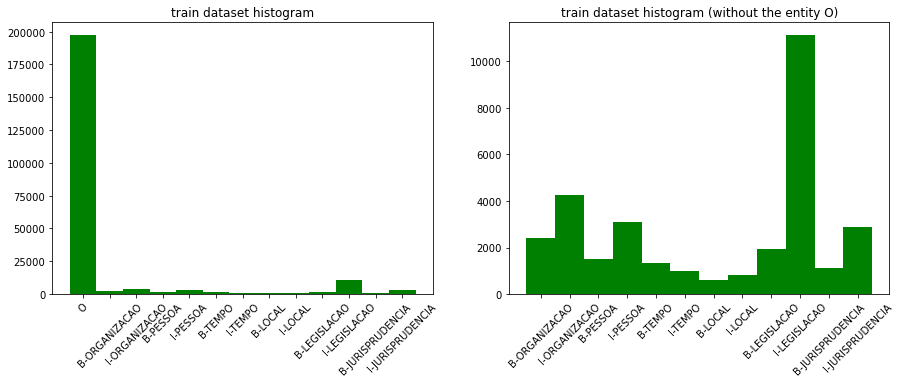

/tmp/ipykernel_8105/2590705613.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  col.set_xticklabels(labels=list(sorted_ner_tags_dist.keys()),rotation=45)
/tmp/ipykernel_8105/2590705613.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  col.set_xticklabels(labels=list(sorted_ner_tags_dist_without_O.keys()),rotation=45)


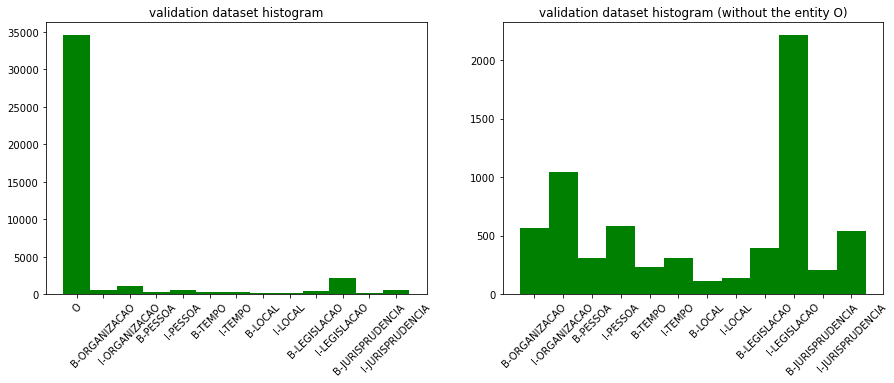

/tmp/ipykernel_8105/2590705613.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  col.set_xticklabels(labels=list(sorted_ner_tags_dist.keys()),rotation=45)
/tmp/ipykernel_8105/2590705613.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  col.set_xticklabels(labels=list(sorted_ner_tags_dist_without_O.keys()),rotation=45)


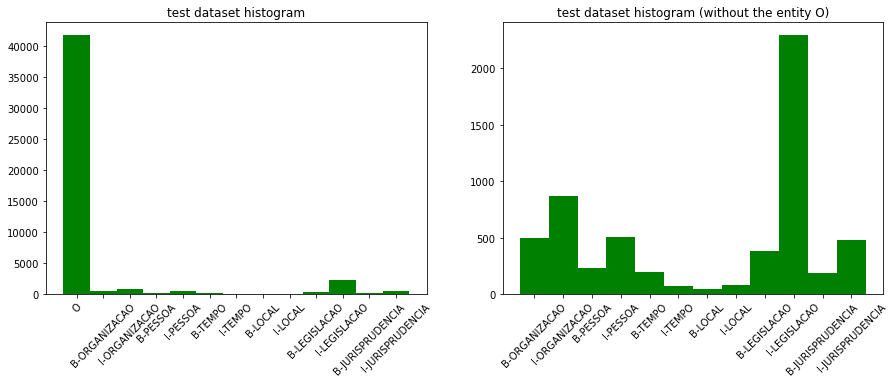

In [11]:
dsets = ["train","validation","test"]
for dset in dsets:
    # all tags
    ner_tags_list = list()
    for i,row in enumerate(datasets[dset]):
        ner_tags_list += row['ner_tags']

    # unique ner tags
    ner_tags_unique = list(set(ner_tags_list))
    ner_tags_unique = [labels[i] for i in ner_tags_unique]

    # Analyse the Tag distribution
    ner_tags_dist = Counter(ner_tags_list)
    ner_tags_dist = {labels[k]:v for k,v in ner_tags_dist.items()}
    sorted_ner_tags_dist = {k:ner_tags_dist[k] for k in labels}
    
    fig = plt.figure(figsize=(15,5))
    axes = fig.subplots(nrows=1, ncols=2)

    for i,col in enumerate(axes):
            if i == 0: 
                col.bar(sorted_ner_tags_dist.keys(), sorted_ner_tags_dist.values(), width=1, color='g')
                col.set_xticklabels(labels=list(sorted_ner_tags_dist.keys()),rotation=45)
                col.set_title(f'{dset} dataset histogram')
            if i == 1:
                sorted_ner_tags_dist_without_O = sorted_ner_tags_dist.copy()
                del_value = sorted_ner_tags_dist_without_O.pop('O')
                col.bar(sorted_ner_tags_dist_without_O.keys(), sorted_ner_tags_dist_without_O.values(), width=1, color='g')
                col.set_xticklabels(labels=list(sorted_ner_tags_dist_without_O.keys()),rotation=45)
                col.set_title(f'{dset} dataset histogram (without the entity O)')

    plt.show()



There are 2 facts: the labels categories are very imbalanced and the train, validation and test datasets distributions are similar (which is a positive point).

As a solution to the first point, we could test a weighted loss function in the trainer.


In [12]:
datasets["train"], datasets["test"], datasets["validation"]

(Dataset({
     features: ['id', 'tokens', 'ner_tags'],
     num_rows: 7828
 }),
 Dataset({
     features: ['id', 'tokens', 'ner_tags'],
     num_rows: 1390
 }),
 Dataset({
     features: ['id', 'tokens', 'ner_tags'],
     num_rows: 1177
 }))

Preprocessing the data



Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers Tokenizer which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the AutoTokenizer.from_pretrained method, which will ensure:

    we get a tokenizer that corresponds to the model architecture we want to use,
    we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.


In [13]:
# TOKENIZER
#
tkzer_checkpoint = "neuralmind/bert-base-portuguese-cased"
tokenizer = AutoTokenizer.from_pretrained(tkzer_checkpoint)

The following assertion ensures that our tokenizer is a fast tokenizers (backed by Rust) from the 🤗 Tokenizers library. Those fast tokenizers are available for almost all models, and we will need some of the special features they have for our preprocessing.

In [14]:
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [15]:
tokenizer("O termo de compromisso deverá ser firmado pelo estagiário.")

{'input_ids': [101, 231, 2476, 125, 11798, 11588, 333, 16315, 243, 423, 418, 2245, 488, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}



Depending on the model you selected, you will see different keys in the dictionary returned by the cell above. They don't matter much for what we're doing here (just know they are required by the model we will instantiate later), you can learn more about them in this tutorial if you're interested.

If, as is the case here, your inputs have already been split into words, you should pass the list of words to your tokenzier with the argument is_split_into_words=True:


In [16]:
tokenizer(["O", "termo", "de", "compromisso", "deverá", "ser", "firmado", "pelo", "estagiário", "."], is_split_into_words=True)

{'input_ids': [101, 231, 2476, 125, 11798, 11588, 333, 16315, 243, 423, 418, 2245, 488, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Note that transformers are often pretrained with subword tokenizers, meaning that even if your inputs have been split into words already, each of those words could be split again by the tokenizer.

For excample, the words "Zwingmann" and "sheepmeat" have been split in three subtokens.

This means that we need to do some processing on our labels as the input ids returned by the tokenizer are longer than the lists of labels our dataset contain, first because some special tokens might be added (we can a [CLS] and a [SEP] above) and then because of those possible splits of words in multiple tokens.

Thankfully, the tokenizer returns outputs that have a word_ids method which can help us.

In [17]:
example = datasets["train"][4]
print(example["tokens"])

['-', 'Preliminar', 'acolhida', 'para', 'reconhecer', 'a', 'nulidade', 'da', 'sentença', '.']


In [18]:
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
print(tokens)

['[CLS]', '-', 'Pre', '##lim', '##inar', 'acolh', '##ida', 'para', 'reconhecer', 'a', 'nu', '##li', '##dade', 'da', 'sentença', '.', '[SEP]']


In [19]:
len(example[f"{task}_tags"]), len(tokenized_input["input_ids"])

(10, 17)

As we can see, it returns a list with the same number of elements as our processed input ids, mapping special tokens to None and all other tokens to their respective word. This way, we can align the labels with the processed input ids.

In [20]:
print(tokenized_input.word_ids())

[None, 0, 1, 1, 1, 2, 2, 3, 4, 5, 6, 6, 6, 7, 8, 9, None]


In [21]:
word_ids = tokenized_input.word_ids()
aligned_labels = [-100 if i is None else example[f"{task}_tags"][i] for i in word_ids]
print(len(aligned_labels), len(tokenized_input["input_ids"]))

17 17


Here we set the labels of all special tokens to -100 (the index that is ignored by PyTorch) and the labels of all other tokens to the label of the word they come from. Another strategy is to set the label only on the first token obtained from a given word, and give a label of -100 to the other subtokens from the same word. We propose the two strategies here, just change the value of the following flag:

In [22]:
label_all_tokens = True



We're now ready to write the function that will preprocess our samples. We feed them to the tokenizer with the argument truncation=True (to truncate texts that are bigger than the maximum size allowed by the model) and is_split_into_words=True (as seen above). Then we align the labels with the token ids using the strategy we picked:


In [23]:
# original function: 1 sentence for the validation and test dataset
def tokenize_and_align_labels(examples):
#     tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True, max_length=512)

    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [27]:
# new with 2 sentences for the training dataset
def tokenize_and_align_labels_next(examples):
#     tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    tokens_sentence = examples["tokens_sentence"]
    tokens_second_sentence = examples["tokens_second_sentence"]
    tokenized_inputs = tokenizer(tokens_sentence, tokens_second_sentence, truncation=True, is_split_into_words=True, max_length=512)

    labels = []
    
    ner_tags_sentence = examples["ner_tags_sentence"]
    ner_tags_second_sentence = examples["ner_tags_second_sentence"]
    ner_tags_list = [tags1+tags2 for tags1, tags2 in zip(ner_tags_sentence, ner_tags_second_sentence)]
    
    for i, label in enumerate(ner_tags_list):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs



This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key.

As you need to pass 2 consecutives sentences, let's create the datasets object new_datasets that contains the 3 datasets train, validation, test with a shifted of one sentence for train. Validation and test stay with just one sentence.


In [24]:
%%time

if next_sentence:
        
    # train dataset
    folders = ['train']
    new_datasets = DatasetDict()

    for folder in folders:    

        # content creation
        new_ids = list()
        tokens_sentence = list()
        tokens_second_sentence = list()
        ner_tags_sentence = list()
        ner_tags_second_sentence = list()

        df = datasets[folder].to_pandas()

        for index, row in df.iterrows():
            new_ids.append(index)
            if index < len(df) - 1:
                tokens_sentence.append(row['tokens'].tolist())
                tokens_second_sentence.append(df['tokens'][index+1].tolist())
                ner_tags_sentence.append(row['ner_tags'].tolist())
                ner_tags_second_sentence.append(df['ner_tags'][index+1].tolist())
            else:
                tokens_sentence.append(row['tokens'].tolist())
                tokens_second_sentence.append(df['tokens'][0].tolist())
                ner_tags_sentence.append(row['ner_tags'].tolist())
                ner_tags_second_sentence.append(df['ner_tags'][0].tolist())

        # new DataFrame
        columns = ['id','tokens_sentence','tokens_second_sentence','ner_tags_sentence','ner_tags_second_sentence']
        df_new = pd.DataFrame(columns=columns)
        df_new['id'] = pd.Series(new_ids)
        df_new['tokens_sentence'] = pd.Series(tokens_sentence)
        df_new['tokens_second_sentence'] = pd.Series(tokens_second_sentence)
        df_new['ner_tags_sentence'] = pd.Series(ner_tags_sentence)
        df_new['ner_tags_second_sentence'] = pd.Series(ner_tags_second_sentence)

        # new Dataset   
        new_datasets[folder] = Dataset.from_pandas(df_new)

        # setup features
        new_datasets[folder].features['tokens_sentence'] = datasets[folder].features['tokens']
        new_datasets[folder].features['tokens_second_sentence'] = datasets[folder].features['tokens']
        new_datasets[folder].features['ner_tags_sentence'] = datasets[folder].features['ner_tags']
        new_datasets[folder].features['ner_tags_second_sentence'] = datasets[folder].features['ner_tags']
        
    # validation and test datasets
    folders = ['validation', 'test']

    for folder in folders:
        if len(datasets[folder][0]['tokens']) > 0:
            new_datasets[folder] = datasets[folder]
        else:
            # we do not keep the first row as it has no content
            new_datasets[folder] = datasets[folder].select(list(range(1,datasets[folder].num_rows)))

CPU times: user 457 ms, sys: 14.2 ms, total: 472 ms
Wall time: 514 ms


In [25]:
if next_sentence:
    print(new_datasets)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens_sentence', 'tokens_second_sentence', 'ner_tags_sentence', 'ner_tags_second_sentence'],
        num_rows: 7828
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1177
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1390
    })
})


In [28]:
if next_sentence:
    print(tokenize_and_align_labels_next(new_datasets['train'][:2]))
else:
    print(tokenize_and_align_labels(datasets['train'][:2]))

{'input_ids': [[101, 192, 7463, 8427, 22301, 131, 12127, 9008, 22301, 22402, 16484, 187, 22360, 22339, 9008, 118, 177, 22402, 16484, 10836, 13760, 7545, 22320, 22323, 22351, 22301, 22402, 16484, 212, 8718, 250, 7665, 6072, 213, 8718, 22301, 6538, 118, 11635, 9008, 13270, 7073, 6765, 118, 11741, 22328, 22341, 6392, 22301, 212, 9008, 22317, 213, 7073, 6538, 22321, 22352, 21748, 22317, 212, 22371, 22318, 22327, 6162, 22317, 192, 22311, 278, 5650, 22341, 257, 5476, 15289, 5903, 22327, 118, 248, 18199, 6392, 11836, 22309, 118, 177, 10409, 22420, 22320, 14298, 22301, 10836, 13760, 16017, 22322, 22339, 12547, 22402, 16484, 15040, 18868, 22322, 22349, 22341, 9208, 248, 22301, 13760, 11846, 22379, 22320, 14298, 22301, 177, 5226, 22341, 22317, 118, 11635, 3341, 12547, 22402, 22301, 10836, 13760, 4529, 5869, 22351, 118, 11635, 22309, 22333, 22341, 22360, 22351, 22317, 192, 22348, 6538, 16017, 8427, 22309, 118, 11635, 9008, 13270, 7073, 6765, 11247, 7918, 22340, 6392, 22301, 118, 248, 18199, 6392,

In [29]:
if next_sentence:
    tokenized_datasets = DatasetDict()
    folders = ['train', 'validation', 'test']

    for folder in folders:
        if folder == 'train':
            tokenized_datasets[folder] = new_datasets[folder].map(tokenize_and_align_labels_next, batched=True,
                                                                   remove_columns=new_datasets[folder].column_names)
        else:
            tokenized_datasets[folder] = new_datasets[folder].map(tokenize_and_align_labels, batched=True,
                                                                  remove_columns=new_datasets[folder].column_names) 
else:
    tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [30]:
tokenized_datasets


DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 7828
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 1177
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 1390
    })
})

In [31]:
# SALVA O DATASET TOKENIZADO.
tokenized_datasets.save_to_disk("/home/info/MyNotebooks/Datasets/LeNER-Br/Tokenized")

In [26]:
# CARREGA O DATASET TOKENIZADO.
tokenized_datasets = datasets.load_from_disk("/home/info/MyNotebooks/Datasets/LeNER-Br/Tokenized")

In [32]:
tokenized_datasets["train"], tokenized_datasets["test"], tokenized_datasets["validation"]

(Dataset({
     features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
     num_rows: 7828
 }),
 Dataset({
     features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
     num_rows: 1390
 }),
 Dataset({
     features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
     num_rows: 1177
 }))

Let's verify that the training dataset has 2 tokonized sentences (token_type_ids = 0 and 1) and validation/test only one (token_type_ids = 0).

In [33]:
folders = ['train', 'validation', 'test']

for folder in folders:
    print(folder, tokenized_datasets[folder][0]['token_type_ids'][:100])

train [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
validation [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
test [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [34]:
for folder in folders:
    print(folder, tokenized_datasets[folder][0]['labels'][:100])

train [-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
validation [-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11, 11, 11, 11, 11, 0, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
test [-100, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11, 11, 12, 12, 12, 12, 0, 1, 1, 1, 1, 1, 1, 0, 0, 3, 3, 3, 3, 3, 4, 4, 4, 4, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, -100]


Let's check the min and max of tokens in our tokenized sentences.

In [35]:
folders = ["train", "validation", "test"]
tokens_length = dict()

for folder in folders:
    tokens_length[folder] = list()
    for i in range(tokenized_datasets[folder].num_rows):
        tokens_length[folder].append(len(tokenized_datasets[folder][i]['token_type_ids']))
    print(f'{folder} min tokens: {min(tokens_length[folder])} - max tokens: {max(tokens_length[folder])}')

train min tokens: 7 - max tokens: 512
validation min tokens: 2 - max tokens: 505
test min tokens: 2 - max tokens: 512


Let's display the histograms of our tokenized train, validation and test set.

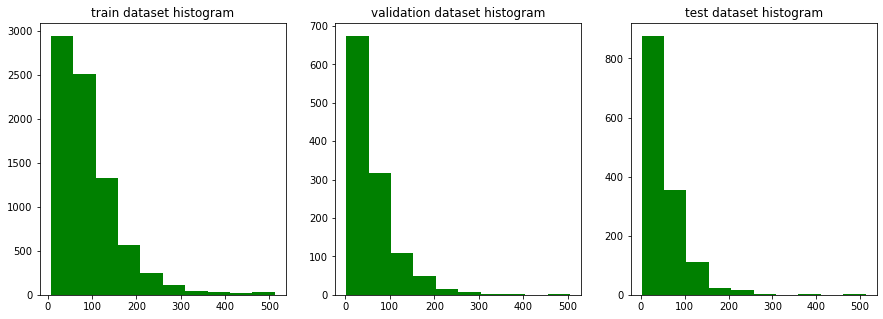

In [36]:
fig = plt.figure(figsize=(15,5))
axes = fig.subplots(nrows=1, ncols=3)

for i,col in enumerate(axes):
    folder = folders[i]
    col.hist(tokens_length[folder], color='g')
    col.set_title(f'{folder} dataset histogram')

plt.show()



Even better, the results are automatically cached by the 🤗 Datasets library to avoid spending time on this step the next time you run your notebook. The 🤗 Datasets library is normally smart enough to detect when the function you pass to map has changed (and thus requires to not use the cache data). For instance, it will properly detect if you change the task in the first cell and rerun the notebook. 🤗 Datasets warns you when it uses cached files, you can pass load_from_cache_file=False in the call to map to not use the cached files and force the preprocessing to be applied again.

Note that we passed batched=True to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.


In [37]:
# NAN on Validation computing
# https://datatofish.com/check-nan-pandas-dataframe/
# https://sparkbyexamples.com/pandas/pandas-drop-rows-with-nan-values-in-dataframe/
tokenized_datasets['validation']

Dataset({
    features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
    num_rows: 1177
})

In [119]:
val_set = pd.DataFrame(tokenized_datasets['validation'])
val_set.isnull().values.any()

False

In [120]:
df_val = val_set.dropna(how='all').reset_index(drop=True)  # inplace=True

In [140]:
x=80
df_val[['attention_mask','token_type_ids']][x:x+21]

,attention_mask,token_type_ids
80,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
81,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
82,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
83,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
84,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
85,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
86,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
87,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
88,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
89,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


Fine-tuning the model

Now that our data is ready, we can download the pretrained model and fine-tune it. Since all our tasks are about token classification, we use the AutoModelForTokenClassification class. Like with the tokenizer, the from_pretrained method will download and cache the model for us. The only thing we have to specify is the number of labels for our problem (which we can get from the features, as seen before):

In [38]:
len(label_list), label_list

(13,
 ['O',
  'B-ORGANIZACAO',
  'I-ORGANIZACAO',
  'B-PESSOA',
  'I-PESSOA',
  'B-TEMPO',
  'I-TEMPO',
  'B-LOCAL',
  'I-LOCAL',
  'B-LEGISLACAO',
  'I-LEGISLACAO',
  'B-JURISPRUDENCIA',
  'I-JURISPRUDENCIA'])

In [39]:
len(labels), labels

(13,
 ['O',
  'B-ORGANIZACAO',
  'I-ORGANIZACAO',
  'B-PESSOA',
  'I-PESSOA',
  'B-TEMPO',
  'I-TEMPO',
  'B-LOCAL',
  'I-LOCAL',
  'B-LEGISLACAO',
  'I-LEGISLACAO',
  'B-JURISPRUDENCIA',
  'I-JURISPRUDENCIA'])

In [40]:
id2label = {id_: label for id_, label in enumerate(labels)}
label2id = {label: id_ for id_, label in enumerate(labels)}
id2label, label2id

({0: 'O',
  1: 'B-ORGANIZACAO',
  2: 'I-ORGANIZACAO',
  3: 'B-PESSOA',
  4: 'I-PESSOA',
  5: 'B-TEMPO',
  6: 'I-TEMPO',
  7: 'B-LOCAL',
  8: 'I-LOCAL',
  9: 'B-LEGISLACAO',
  10: 'I-LEGISLACAO',
  11: 'B-JURISPRUDENCIA',
  12: 'I-JURISPRUDENCIA'},
 {'O': 0,
  'B-ORGANIZACAO': 1,
  'I-ORGANIZACAO': 2,
  'B-PESSOA': 3,
  'I-PESSOA': 4,
  'B-TEMPO': 5,
  'I-TEMPO': 6,
  'B-LOCAL': 7,
  'I-LOCAL': 8,
  'B-LEGISLACAO': 9,
  'I-LEGISLACAO': 10,
  'B-JURISPRUDENCIA': 11,
  'I-JURISPRUDENCIA': 12})

In [41]:
# MODEL

#from transformers import AutoModel

#checkpoint = "/home/info/MyNotebooks/bert-base-portuguese-cased-finetuned-ACP/checkpoint-1500/"
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list), id2label=id2label, label2id=label2id)
#model2 = AutoModel.from_pretrained(checkpoint)

Some weights of the model checkpoint at /home/info/MyNotebooks/bert-base-portuguese-cased-finetuned-ACP/checkpoint-1500/ were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from 

The warning is telling us we are throwing away some weights (the vocab_transform and vocab_layer_norm layers) and randomly initializing some other (the pre_classifier and classifier layers). This is absolutely normal in this case, because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

In [42]:
# number of model parameters
model_num_param=0
for p in model.parameters():
    model_num_param+=p.numel()
model_num_param

108342541

In [43]:
print(" Model Checkpoint tem ",333360141 - model_num_param,"parametros a mais.")

 Model Checkpoint tem  225017600 parametros a mais.


In [44]:
model.config
# Nao teriamos que configurar previamente o id2label e label2id?

BertConfig {
  "_name_or_path": "/home/info/MyNotebooks/bert-base-portuguese-cased-finetuned-ACP/checkpoint-1500/",
  "adapters": {
    "adapters": {},
    "config_map": {},
    "fusion_config_map": {},
    "fusions": {}
  },
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-ORGANIZACAO",
    "2": "I-ORGANIZACAO",
    "3": "B-PESSOA",
    "4": "I-PESSOA",
    "5": "B-TEMPO",
    "6": "I-TEMPO",
    "7": "B-LOCAL",
    "8": "I-LOCAL",
    "9": "B-LEGISLACAO",
    "10": "I-LEGISLACAO",
    "11": "B-JURISPRUDENCIA",
    "12": "I-JURISPRUDENCIA"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-JURISPRUDENCIA": 11,
    "B-LEGISLACAO": 9,
    "B-LOCAL": 7,
    "B-ORGANIZACAO": 1,
    "B-PESSOA": 3,
    "B-TEMPO": 5,
    "I-JURISPRUDENCIA": 12,
  

In [ ]:
# model.config.adapters

9. Adapters

In [45]:
# Setup adapters

if train_adapter:
        
    # new
    if madx2:
        # do not add adapter in the last transformer layers 
        leave_out = [len(model.bert.encoder.layer)-1]
    else:
        leave_out = []
        
    # new
    # task_name = data_args.dataset_name or "mlm"
    task_name = "ner"
    
    # optionally load another pre-trained language adapter
    if with_adapters_mlm:
        # resolve the language adapter config
        lang_adapter_config = AdapterConfig.load(
                lang_adapter_config,
                non_linearity=lang_adapter_non_linearity,
                reduction_factor=lang_adapter_reduction_factor,
                leave_out=leave_out,
            )
        # load the language adapter from Hub
        task_mlm_load_as = 'mlm'
        lang_adapter_name = model.load_adapter(
                load_lang_adapter,
                config=lang_adapter_config,
                load_as=task_mlm_load_as,
                with_head = False
            )
    else:
        lang_adapter_name = None
        
    # check if adapter already exists, otherwise add it
    if task_name not in model.config.adapters:
            
#             # resolve the adapter config
#             adapter_config = AdapterConfig.load(
#                 adapter_args.adapter_config,
#                 non_linearity=adapter_args.adapter_non_linearity,
#                 reduction_factor=adapter_args.adapter_reduction_factor,
#             )

        # new
        # resolve adapter config with (eventually) the MAD-X 2.0 option
        if adapter_config_name == "pfeiffer":
            from transformers.adapters.configuration import PfeifferConfig
            adapter_config = PfeifferConfig(non_linearity=adapter_non_linearity,
                                            reduction_factor=adapter_reduction_factor,
                                            leave_out=leave_out)           
        elif adapter_config_name == "pfeiffer+inv":
            from transformers.adapters.configuration import PfeifferInvConfig
            adapter_config = PfeifferInvConfig(non_linearity=adapter_non_linearity,
                                               reduction_factor=adapter_reduction_factor,
                                               leave_out=leave_out)          
        elif adapter_config_name == "houlsby":
            from transformers.adapters.configuration import HoulsbyConfig
            adapter_config = HoulsbyConfig(non_linearity=adapter_non_linearity,
                                           reduction_factor=adapter_reduction_factor,
                                           leave_out=leave_out)
        elif adapter_config_name == "houlsby+inv":
            from transformers.adapters.configuration import HoulsbyInvConfig
            adapter_config = HoulsbyInvConfig(non_linearity=adapter_non_linearity,
                                              reduction_factor=adapter_reduction_factor,
                                              leave_out=leave_out)              
                
        # load a pre-trained from Hub if specified
        if load_adapter:
            model.load_adapter(
                    load_adapter,
                    config=adapter_config,
                    load_as=task_name,
                    with_head = False
                )
        # otherwise, add a fresh adapter
        else:
            model.add_adapter(task_name, config=adapter_config)
            
    # Set the adapters to be used in every forward pass
    if lang_adapter_name:
        model.active_adapters = Stack(task_mlm_load_as, task_name)
    else:
        model.set_active_adapters(task_name)

    # Freeze all model weights except of those of this adapter
    model.train_adapter([task_name])
    
else:
    if load_adapter or load_lang_adapter:
        raise ValueError(
                "Adapters can only be loaded in adapters training mode."
                "Use --train_adapter to enable adapter training"
            )


In [46]:
# Put only the adapter after the MHA but not after the FeedForward in the last layer
if houlsby_MHA_lastlayer \
and train_adapter \
and not madx2 \
and task_name in model.config.adapters \
and (adapter_config_name == "houlsby" or adapter_config_name == "houlsby+inv"):
    model.bert.encoder.layer[len(model.bert.encoder.layer)-1].output.adapters = ModuleDict()

In [47]:
model_adapter_num_param=0
for p in model.parameters():
    model_adapter_num_param+=p.numel()
model_adapter_num_param

109162525

In [48]:
print(f"Number of parameters of the model with adapter: {model_adapter_num_param:.0f}")
print(f"Number of parameters of the model without adapter: {model_num_param:.0f}")
print(f"Number of parameters of the adapter: {model_adapter_num_param - model_num_param:.0f}")
print(f"Pourcentage of additional parameters through adapter:",round(((model_adapter_num_param - model_num_param)/model_num_param)*100,2),'%')


Number of parameters of the model with adapter: 109162525
Number of parameters of the model without adapter: 108342541
Number of parameters of the adapter: 819984
Pourcentage of additional parameters through adapter: 0.76 %


10. Training

In [49]:

if ds:
    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=overwrite_output_dir,
        do_train=do_train,
        do_eval=do_eval,
        evaluation_strategy=evaluation_strategy,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        adam_beta1=adam_beta1,
        adam_beta2=adam_beta2,
        adam_epsilon=adam_epsilon,
        num_train_epochs=num_train_epochs,
        lr_scheduler_type=lr_scheduler_type,
        warmup_ratio=warmup_ratio,
        warmup_steps=warmup_steps,
        logging_dir=logging_dir,         # directory for storing logs
        logging_strategy=evaluation_strategy,
        logging_steps=logging_steps,     # if strategy = "steps"
        save_strategy=evaluation_strategy,          # model checkpoint saving strategy
        save_steps=logging_steps,        # if strategy = "steps"
        save_total_limit=save_total_limit,
        #fp16=fp16,
        eval_steps=logging_steps,        # if strategy = "steps"
        load_best_model_at_end=load_best_model_at_end,
        metric_for_best_model=metric_for_best_model,
        greater_is_better=greater_is_better,
        #local_rank=gpu,
        #deepspeed = ds_config
        )
else:
    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=overwrite_output_dir,
        do_train=do_train,
        do_eval=do_eval,
        evaluation_strategy=evaluation_strategy,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        adam_beta1=adam_beta1,
        adam_beta2=adam_beta2,
        adam_epsilon=adam_epsilon,
        num_train_epochs=num_train_epochs,
        lr_scheduler_type=lr_scheduler_type,
        warmup_ratio=warmup_ratio,
        warmup_steps=warmup_steps,
        logging_dir=logging_dir,         # directory for storing logs
        logging_strategy=evaluation_strategy,
        logging_steps=logging_steps,     # if strategy = "steps"
        save_strategy=evaluation_strategy,          # model checkpoint saving strategy
        save_steps=logging_steps,        # if strategy = "steps"
        save_total_limit=save_total_limit,
        #fp16=fp16,
        eval_steps=logging_steps,        # if strategy = "steps"
        load_best_model_at_end=load_best_model_at_end,
        metric_for_best_model=metric_for_best_model,
        greater_is_better=greater_is_better,
        #local_rank=gpu,
        )


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [50]:
data_collator = DataCollatorForTokenClassification(tokenizer)

The last thing to define for our Trainer is how to compute the metrics from the predictions. Here we will load the seqeval metric (which is commonly used to evaluate results on the CONLL dataset) via the Datasets library.

In [51]:
metric = load_metric("seqeval")

In [ ]:
#example = tokenized_datasets["validation"][0]

This metric takes list of labels for the predictions and references:

In [52]:
if next_sentence:
    example = new_datasets["validation"][0]
    #example = tokenized_datasets["validation"][0]
else:
    example = datasets["validation"][0]
    #example = tokenized_datasets["validation"][0]

labels = [label_list[i] for i in example[f"{task}_tags"]]
metric.compute(predictions=[labels], references=[labels])

{'JURISPRUDENCIA': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 3},
 'ORGANIZACAO': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 2},
 'PESSOA': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 2},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}



So we will need to do a bit of post-processing on our predictions:

    select the predicted index (with the maximum logit) for each token
    convert it to its string label
    ignore everywhere we set a label of -100

The following function does all this post-processing on the result of Trainer.evaluate (which is a namedtuple containing predictions and labels) before applying the metric:


In [53]:

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }


In [54]:
sorted_ner_tags_dist

{'O': 41807,
 'B-ORGANIZACAO': 501,
 'I-ORGANIZACAO': 866,
 'B-PESSOA': 233,
 'I-PESSOA': 502,
 'B-TEMPO': 192,
 'I-TEMPO': 68,
 'B-LOCAL': 47,
 'I-LOCAL': 85,
 'B-LEGISLACAO': 378,
 'I-LEGISLACAO': 2291,
 'B-JURISPRUDENCIA': 185,
 'I-JURISPRUDENCIA': 475}

In [55]:

if weighted_loss:

    # https://discuss.pytorch.org/t/what-is-the-weight-values-mean-in-torch-nn-crossentropyloss/11455/2
    # https://discuss.pytorch.org/t/what-is-the-weight-values-mean-in-torch-nn-crossentropyloss/11455/4
    # source: https://medium.com/swlh/approaching-a-named-entity-recognition-ner-end-to-end-steps-685735b4a2f9#5194
    class_LabelCounts = [v for v in sorted_ner_tags_dist.values()]

    inverse_weights = [1 / lc for lc in class_LabelCounts]
    sum_inverse = np.sum(inverse_weights)
    normalized_inverse_weights = inverse_weights / sum_inverse

    constant = c
    class_weights = constant + normalized_inverse_weights
    normalized_weights = class_weights / np.sum(class_weights)
    
    # customized trainer class with weighted loss
    # from transformers import Trainer
    # import math
    # from torch.nn import CrossEntropyLoss

    # device = torch.device(f"cuda:{gpu}")
#     torch.cuda.set_device(gpu)
    normalized_class_weights = torch.from_numpy(normalized_weights).float().to(device)
    if ds:
        normalized_class_weights = normalized_class_weights.half()

    class MyTrainer(Trainer):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)    

        # https://huggingface.co/transformers/_modules/transformers/trainer.html#Trainer.compute_loss
        # https://github.com/huggingface/transformers/blob/master/src/transformers/models/bert/modeling_bert.py#L1711
        def compute_loss(self, model, inputs, return_outputs=False):
            """
            How the loss is computed by Trainer. By default, all models return the loss in the first element.

            Subclass and override for custom behavior.
            """

            labels = inputs.pop("labels")
            attention_mask = inputs['attention_mask']
            
            outputs = model(**inputs)
            logits = outputs.logits
            num_labels = logits.shape[2]
        
            loss = None
            
            if labels is not None:
#                 loss_fct = torch.nn.CrossEntropyLoss()
                loss_fct = torch.nn.CrossEntropyLoss(weight=normalized_class_weights, reduction='mean') # mean in order to normalize the loss
                
                # Only keep active parts of the loss
                if attention_mask is not None:
                    active_loss = attention_mask.view(-1) == 1
                    active_logits = logits.view(-1, num_labels)
                    active_labels = torch.where(
                        active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
                    )
                    loss = loss_fct(active_logits, active_labels)
                else:
                    loss = loss_fct(logits.view(-1, num_labels), labels.view(-1))
                
            return (loss, outputs) if return_outputs else loss

In [56]:
if weighted_loss:
    trainer = MyTrainer(
        model,
        training_args,
        train_dataset=tokenized_datasets["train"], #.shard(index=1, num_shards=50), #to be used to reduce train to 1/50
        eval_dataset=tokenized_datasets["validation"], #.shard(index=1, num_shards=50), #to be used to reduce validation to 1/50
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)],
    )        
else:
    trainer = Trainer(
        model,
        training_args,
        train_dataset=tokenized_datasets["train"], #.shard(index=1, num_shards=50), #to be used to reduce train to 1/50
        eval_dataset=tokenized_datasets["validation"], #.shard(index=1, num_shards=50), #to be used to reduce validation to 1/50
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)],
    )

In [57]:
outputs

'NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer'

In [ ]:
# import pixiedust

In [ ]:
#%%pixie_debugger
# %debug
#train_result = trainer.train()

In [58]:
trainer.train()
# Usar ferramentas de debug.

/home/info/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 7828
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2937


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.569500,nan,0.552386,0.612258,0.580783,0.942006
2,0.369900,nan,0.680851,0.674409,0.677615,0.955278
3,0.338300,nan,0.683316,0.700215,0.691662,0.957578


***** Running Evaluation *****
  Num examples = 1177
  Batch size = 8
Saving model checkpoint to /home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/output_dir/checkpoint-979
Configuration saved in /home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/output_dir/checkpoint-979/config.json
Model weights saved in /home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/output_dir/checkpoint-979/pytorch_mod

TrainOutput(global_step=2937, training_loss=0.42590740386994064, metrics={'train_runtime': 4995.0387, 'train_samples_per_second': 4.701, 'train_steps_per_second': 0.588, 'total_flos': 2547187873126104.0, 'train_loss': 0.42590740386994064, 'epoch': 3.0})

In [ ]:
'''
/home/info/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 7828
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2937
  

Epoch 	Training Loss 	Validation Loss 	Precision 	Recall 	F1 	Accuracy
1 	0.586800 	nan 	0.630430 	0.646022 	0.638131 	0.946699
2 	0.379100 	nan 	0.723347 	0.698925 	0.710926 	0.956847
3 	0.342000 	nan 	0.724956 	0.715914 	0.720407 	0.959392


***** Running Evaluation *****
  Num examples = 1177
  Batch size = 8

Saving model checkpoint to /home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/output_dir/checkpoint-2937
Configuration saved in /home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/output_dir/checkpoint-2937/config.json
Model weights saved in /home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/output_dir/checkpoint-2937/pytorch_model.bin
tokenizer config file saved in /home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/output_dir/checkpoint-2937/tokenizer_config.json
Special tokens file saved in /home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/output_dir/checkpoint-2937/special_tokens_map.json
Deleting older checkpoint [/home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/output_dir/checkpoint-1958] due to args.save_total_limit

Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/output_dir/checkpoint-2937 (score: 0.7204068383466782).
'''

In [59]:
# save adapter + head
adapters_folder = 'adapters-' + task_name
path_to_save_adapter = path_to_outputs/adapters_folder
trainer.model.save_adapter(str(path_to_save_adapter), adapter_name=task_name, with_head=True)

!ls -lh {path_to_save_adapter}

Configuration saved in /home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/adapters-ner/adapter_config.json
Module weights saved in /home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/adapters-ner/pytorch_adapter.bin
Configuration saved in /home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/adapters-ner/head_config.json
Module weights saved in /home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert

total 3,2M
-rw-rw-r-- 1 info info 1006 Aug  5 03:35 adapter_config.json
-rw-rw-r-- 1 info info  486 Aug  5 03:35 head_config.json
-rw-rw-r-- 1 info info 3,2M Aug  5 03:35 pytorch_adapter.bin
-rw-rw-r-- 1 info info  40K Aug  5 03:35 pytorch_model_head.bin


In [ ]:
'''
Configuration saved in /home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/adapters-ner/adapter_config.json
Module weights saved in /home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/adapters-ner/pytorch_adapter.bin
Configuration saved in /home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/adapters-ner/head_config.json
Module weights saved in /home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/adapters-ner/pytorch_model_head.bin
'''

In [60]:
path_to_save_adapter

PosixPath('/home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/adapters-ner')

In [ ]:
'''
PosixPath('/home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/adapters-ner')
'''

In [ ]:
'''
Creio que a configuração para usar o Adapter seja:

model_checkpoint = "/home/info/MyNotebooks/bert-base-portuguese-cased-finetuned-ACP/checkpoint-1500/"

root = Path("/home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP")
root = Path(root)     


Adapter Configuration in: /home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/adapters-ner/



OU:

BASE ('Saving model checkpoint to' or 'Loading best model from'):
 /home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/output_dir/checkpoint-2937

ADAPTER (path_to_save_adapter):
/home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/adapters-ner

'''

11. Evaluation

In [61]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1177
  Batch size = 8


{'eval_loss': nan,
 'eval_precision': 0.6833158447009444,
 'eval_recall': 0.7002150537634408,
 'eval_f1': 0.6916622411046204,
 'eval_accuracy': 0.9575784357048166,
 'eval_runtime': 79.6729,
 'eval_samples_per_second': 14.773,
 'eval_steps_per_second': 1.858,
 'epoch': 3.0}

In [ ]:
'''
{'eval_loss': nan,
 'eval_precision': 0.7249564459930313,
 'eval_recall': 0.7159139784946237,
 'eval_f1': 0.7204068383466782,
 'eval_accuracy': 0.959391713776342,
 'eval_runtime': 71.6175,
 'eval_samples_per_second': 16.435,
 'eval_steps_per_second': 2.067,
 'epoch': 3.0}
'''

In [62]:
predictions, labels, _ = trainer.predict(tokenized_datasets["validation"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

***** Running Prediction *****
  Num examples = 1177
  Batch size = 8


{'JURISPRUDENCIA': {'precision': 0.3779264214046823,
  'recall': 0.3439878234398782,
  'f1': 0.3601593625498008,
  'number': 657},
 'LEGISLACAO': {'precision': 0.6900175131348512,
  'recall': 0.6900175131348512,
  'f1': 0.6900175131348512,
  'number': 571},
 'LOCAL': {'precision': 0.2830188679245283,
  'recall': 0.3865979381443299,
  'f1': 0.32679738562091504,
  'number': 194},
 'ORGANIZACAO': {'precision': 0.6068702290076335,
  'recall': 0.5932835820895522,
  'f1': 0.6000000000000001,
  'number': 1340},
 'PESSOA': {'precision': 0.9539040451552211,
  'recall': 0.9458955223880597,
  'f1': 0.9498829039812647,
  'number': 1072},
 'TEMPO': {'precision': 0.7849686847599165,
  'recall': 0.9215686274509803,
  'f1': 0.8478015783540023,
  'number': 816},
 'overall_precision': 0.6833158447009444,
 'overall_recall': 0.7002150537634408,
 'overall_f1': 0.6916622411046204,
 'overall_accuracy': 0.9575784357048166}

In [63]:
pd.DataFrame(results)

,JURISPRUDENCIA,LEGISLACAO,LOCAL,ORGANIZACAO,PESSOA,TEMPO,overall_precision,overall_recall,overall_f1,overall_accuracy
precision,0.377926,0.690018,0.283019,0.606870,0.953904,0.784969,0.683316,0.700215,0.691662,0.957578
recall,0.343988,0.690018,0.386598,0.593284,0.945896,0.921569,0.683316,0.700215,0.691662,0.957578
f1,0.360159,0.690018,0.326797,0.600000,0.949883,0.847802,0.683316,0.700215,0.691662,0.957578
number,657.000000,571.000000,194.000000,1340.000000,1072.000000,816.000000,0.683316,0.700215,0.691662,0.957578


In [ ]:
'''

***** Running Prediction *****
  Num examples = 1177
  Batch size = 8

{'JURISPRUDENCIA': {'precision': 0.3576388888888889,
  'recall': 0.3135464231354642,
  'f1': 0.3341443633414436,
  'number': 657},
 'LEGISLACAO': {'precision': 0.7201492537313433,
  'recall': 0.6760070052539404,
  'f1': 0.6973803071364046,
  'number': 571},
 'LOCAL': {'precision': 0.34701492537313433,
  'recall': 0.4793814432989691,
  'f1': 0.4025974025974026,
  'number': 194},
 'ORGANIZACAO': {'precision': 0.6523101018010963,
  'recall': 0.6216417910447761,
  'f1': 0.6366068016813144,
  'number': 1340},
 'PESSOA': {'precision': 0.9705882352941176,
  'recall': 0.9542910447761194,
  'f1': 0.962370649106303,
  'number': 1072},
 'TEMPO': {'precision': 0.8944381384790011,
  'recall': 0.9656862745098039,
  'f1': 0.928697701826753,
  'number': 816},
 'overall_precision': 0.7249564459930313,
 'overall_recall': 0.7159139784946237,
 'overall_f1': 0.7204068383466782,
 'overall_accuracy': 0.959391713776342}
 

JURISPRUDENCIA 	LEGISLACAO 	LOCAL 	ORGANIZACAO 	PESSOA 	TEMPO 	overall_precision 	overall_recall 	overall_f1 	overall_accuracy
precision 	0.357639 	0.720149 	0.347015 	0.652310 	0.970588 	0.894438 	0.724956 	0.715914 	0.720407 	0.959392
recall 	0.313546 	0.676007 	0.479381 	0.621642 	0.954291 	0.965686 	0.724956 	0.715914 	0.720407 	0.959392
f1 	0.334144 	0.697380 	0.402597 	0.636607 	0.962371 	0.928698 	0.724956 	0.715914 	0.720407 	0.959392
number 	657.000000 	571.000000 	194.000000 	1340.000000 	1072.000000 	816.000000 	0.724956 	0.715914 	0.720407 	0.959392
'''

Test

In [64]:
trainer.evaluate(tokenized_datasets["test"])

***** Running Evaluation *****
  Num examples = 1390
  Batch size = 8


{'eval_loss': 0.10147732496261597,
 'eval_precision': 0.6979727995894278,
 'eval_recall': 0.7003089598352215,
 'eval_f1': 0.6991389281583344,
 'eval_accuracy': 0.9674445277692002,
 'eval_runtime': 82.7041,
 'eval_samples_per_second': 16.807,
 'eval_steps_per_second': 2.104,
 'epoch': 3.0}

In [ ]:
'''
{'eval_loss': 0.10461320728063583,
 'eval_precision': 0.7238785925329035,
 'eval_recall': 0.6938722966014418,
 'eval_f1': 0.7085579071907453,
 'eval_accuracy': 0.9672533709765171,
 'eval_runtime': 76.2975,
 'eval_samples_per_second': 18.218,
 'eval_steps_per_second': 2.281,
 'epoch': 3.0}
'''

In [65]:
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results


***** Running Prediction *****
  Num examples = 1390
  Batch size = 8


{'JURISPRUDENCIA': {'precision': 0.6589673913043478,
  'recall': 0.4507434944237918,
  'f1': 0.5353200883002207,
  'number': 1076},
 'LEGISLACAO': {'precision': 0.7354709418837675,
  'recall': 0.6577060931899642,
  'f1': 0.6944181646168402,
  'number': 558},
 'LOCAL': {'precision': 0.3504273504273504,
  'recall': 0.6029411764705882,
  'f1': 0.4432432432432432,
  'number': 68},
 'ORGANIZACAO': {'precision': 0.5806188925081434,
  'recall': 0.7465968586387435,
  'f1': 0.6532295006871279,
  'number': 955},
 'PESSOA': {'precision': 0.8450244698205547,
  'recall': 0.9522058823529411,
  'f1': 0.8954191875540191,
  'number': 544},
 'TEMPO': {'precision': 0.8465909090909091,
  'recall': 0.8726207906295754,
  'f1': 0.8594087959625091,
  'number': 683},
 'overall_precision': 0.6979727995894278,
 'overall_recall': 0.7003089598352215,
 'overall_f1': 0.6991389281583344,
 'overall_accuracy': 0.9674445277692002}

In [66]:
pd.DataFrame(results)

,JURISPRUDENCIA,LEGISLACAO,LOCAL,ORGANIZACAO,PESSOA,TEMPO,overall_precision,overall_recall,overall_f1,overall_accuracy
precision,0.658967,0.735471,0.350427,0.580619,0.845024,0.846591,0.697973,0.700309,0.699139,0.967445
recall,0.450743,0.657706,0.602941,0.746597,0.952206,0.872621,0.697973,0.700309,0.699139,0.967445
f1,0.535320,0.694418,0.443243,0.653230,0.895419,0.859409,0.697973,0.700309,0.699139,0.967445
number,1076.000000,558.000000,68.000000,955.000000,544.000000,683.000000,0.697973,0.700309,0.699139,0.967445


In [ ]:
'''
***** Running Prediction *****
  Num examples = 1390
  Batch size = 8

{'JURISPRUDENCIA': {'precision': 0.651925820256776,
  'recall': 0.4247211895910781,
  'f1': 0.5143500281373101,
  'number': 1076},
 'LEGISLACAO': {'precision': 0.7194388777555111,
  'recall': 0.6433691756272402,
  'f1': 0.6792809839167454,
  'number': 558},
 'LOCAL': {'precision': 0.3761467889908257,
  'recall': 0.6029411764705882,
  'f1': 0.4632768361581921,
  'number': 68},
 'ORGANIZACAO': {'precision': 0.6302447552447552,
  'recall': 0.7549738219895288,
  'f1': 0.6869938065745592,
  'number': 955},
 'PESSOA': {'precision': 0.8519134775374376,
  'recall': 0.9411764705882353,
  'f1': 0.8943231441048035,
  'number': 544},
 'TEMPO': {'precision': 0.9043348281016442,
  'recall': 0.8857979502196194,
  'f1': 0.8949704142011834,
  'number': 683},
 'overall_precision': 0.7238785925329035,
 'overall_recall': 0.6938722966014418,
 'overall_f1': 0.7085579071907453,
 'overall_accuracy': 0.9672533709765171}


JURISPRUDENCIA 	LEGISLACAO 	LOCAL 	ORGANIZACAO 	PESSOA 	TEMPO 	overall_precision 	overall_recall 	overall_f1 	overall_accuracy
precision 	0.651926 	0.719439 	0.376147 	0.630245 	0.851913 	0.904335 	0.723879 	0.693872 	0.708558 	0.967253
recall 	0.424721 	0.643369 	0.602941 	0.754974 	0.941176 	0.885798 	0.723879 	0.693872 	0.708558 	0.967253
f1 	0.514350 	0.679281 	0.463277 	0.686994 	0.894323 	0.894970 	0.723879 	0.693872 	0.708558 	0.967253
number 	1076.000000 	558.000000 	68.000000 	955.000000 	544.000000 	683.000000 	0.723879 	0.693872 	0.708558 	0.967253
'''

12. TensorBoard

In [67]:
#!pip install tensorboard

In [67]:
PATH = os.getenv('PATH')
# replace xxxx by your username on your server (ex: paulo)
# replace yyyy by the name of the virtual environment of this notebook (ex: adapter-transformers)
%env PATH=/mnt/home/xxxx/anaconda3/envs/yyyy/bin:$PATH

env: PATH=/mnt/home/xxxx/anaconda3/envs/yyyy/bin:/home/info/.conda/envs/acptrt1/bin:/home/info/anaconda3/condabin:/home/info/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin


In [68]:
# pip install --upgrade tensorflow
#%load_ext tensorboard
%reload_ext tensorboard
# %reload_ext tensorboard
%tensorboard --logdir {logging_dir} --bind_all

13. Application NER

In [142]:
### import transformers
# !pip install colorama
# # or
#!conda install -c anaconda colorama


In [79]:
#model_checkpoint = "neuralmind/bert-large-portuguese-cased"

#BASE ('Saving model checkpoint to' or 'Loading best model from'):

model_checkpoint = "/home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/output_dir/checkpoint-2937"

#ADAPTER (path_to_save_adapter):
model_output = "/home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/adapters-ner"


'''
model_checkpoint = "/home/info/MyNotebooks/bert-base-portuguese-cased-finetuned-ACP/checkpoint-1500/"

root = Path("/home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP")
root = Path(root)
root 
'''
# Ou:
'''
BASE:
/home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/output_dir/checkpoint-979
ADAPTER:
/home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/adapters-ner
'''


# Ou:
'''
model_checkpoint = "/home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/output_dir/checkpoint-2937"

root = Path("/home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/")
root = Path(root)
root
'''

# Ou:
'''
model_checkpoint = "/home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/adapters-ner"

root = Path("/home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/")
root = Path(root)
root
'''

'\nmodel_checkpoint = "/home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/adapters-ner"\n\nroot = Path("/home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/")\nroot = Path(root)\nroot\n'

In [80]:
if dataset_name == "lenerbr":
    label_list = ['O',
 'B-ORGANIZACAO',
 'I-ORGANIZACAO',
 'B-PESSOA',
 'I-PESSOA',
 'B-TEMPO',
 'I-TEMPO',
 'B-LOCAL',
 'I-LOCAL',
 'B-LEGISLACAO',
 'I-LEGISLACAO',
 'B-JURISPRUDENCIA',
 'I-JURISPRUDENCIA'
                 ]

In [97]:


if dataset_name == "LeNER-Br":
    
    # sentence from the dataset
    texts_dataset = [
        'Acrescento que o Juiz Pedro DA SILVA do tribunal STF em Brasília (Brasil) reconheceu a limitação do pedido único e, com base no artigo 487, inciso II, do Código de Processo Civil, encerrou o processo no dia 3 de janeiro de 2014, com resolução do mérito, condenando o autor às custas judiciais e advocatícias, que são fixadas em 10% (dez por cento) do valor da causa.',
        'Insurge-se no apelo extremo contra acórdão proferido pelo Superior Tribunal Militar no Agravo Regimental n° 222-73.2010.7.05.0005/PR, assim do: DESERÇÃO.'
    ]
    
    texts_labels = [
        "",
        "'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZACAO', 'I-ORGANIZACAO', 'I-ORGANIZACAO', 'O', 'B-JURISPRUDENCIA', 'I-JURISPRUDENCIA', 'I-JURISPRUDENCIA', 'I-JURISPRUDENCIA', 'I-JURISPRUDENCIA', 'O', 'O', 'O', 'O', 'O', 'O'"
    ]



In [98]:
texts_dataset

['Acrescento que o Juiz Pedro DA SILVA do tribunal STF em Brasília (Brasil) reconheceu a limitação do pedido único e, com base no artigo 487, inciso II, do Código de Processo Civil, encerrou o processo no dia 3 de janeiro de 2014, com resolução do mérito, condenando o autor às custas judiciais e advocatícias, que são fixadas em 10% (dez por cento) do valor da causa.',
 'Insurge-se no apelo extremo contra acórdão proferido pelo Superior Tribunal Militar no Agravo Regimental n° 222-73.2010.7.05.0005/PR, assim do: DESERÇÃO.']

Model with adapters

In [82]:
model_ner = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list), id2label=id2label, label2id=label2id)
tokenizer_ner = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

loading configuration file /home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/output_dir/checkpoint-2937/config.json
Model config BertConfig {
  "_name_or_path": "/home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/output_dir/checkpoint-2937",
  "adapters": {
    "adapters": {
      "ner": "55afc146b84997d9"
    },
    "config_map": {
      "55afc146b84997d9": {
        "adapter_residual_before_ln": false,
        "cross_adapter": false,
        "factorized_phm_W": true,
        "factorized_phm_rule": false,
        "hypercomplex_nonlinearity": "glorot-uniform",
        "init_weights": "bert"

loading file /home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/output_dir/checkpoint-2937/tokenizer.json
loading file None
loading file /home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/output_dir/checkpoint-2937/special_tokens_map.json
loading file /home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/output_dir/checkpoint-2937/tokenizer_config.json


Lang adapter

In [83]:
if with_adapters_mlm:
    
    # hyperparameters used for fine-tuning the MLM with lang adapter
    learning_rate_mlm = 1e-4
    batch_size_mlm = 16
    gradient_accumulation_steps_mlm = 1
    adam_epsilon_mlm = 1e-6
    num_train_epoch_mlm = 100.
    early_stopping_patience_mlm = 10
    madx2_mlm = True
    houlsby_MHA_lastlayer_mlm = False
    ds_mlm = False
    fp16_mlm = True
    load_best_model_at_end_mlm = True
    metric_for_best_model_mlm = "loss"
    adapter_config_mlm = 'pfeiffer+inv'

    # path to lang adapter
    outputs_mlm = model_checkpoint.replace('/','-') + '_' + dataset_name + '/' + 'mlm' + '/' \
    + 'lr' + str(learning_rate_mlm) \
    + '_bs' + str(batch_size_mlm) \
    + '_GAS' + str(gradient_accumulation_steps_mlm) \
    + '_eps' + str(adam_epsilon_mlm) \
    + '_epochs' + str(num_train_epoch_mlm) \
    + '_patience' + str(early_stopping_patience_mlm) \
    + '_madx2' + str(madx2_mlm) \
    + '_houlsby_MHA_lastlayer' + str(houlsby_MHA_lastlayer_mlm) \
    + '_ds' + str(ds_mlm) \
    + '_fp16' + str(fp16_mlm) \
    + '_best' + str(load_best_model_at_end_mlm) \
    + '_metric' + str(metric_for_best_model_mlm) \
    + '_adapterconfig' + str(adapter_config_mlm)

    path_to_outputs_mlm = root/'outputs'/outputs_mlm

    # Config of the lang adapter
    lang_adapter_path = path_to_outputs_mlm/'adapters-mlm/'

    #load_lang_adapter = str(lang_adapter_path)
    load_lang_adapter = "/home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/adapters-ner"
    #'/home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP-Bert_LeNER-Br/mlm/lr0.0001_bs16_GAS1_eps1e-06_epochs100.0_patience10_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricloss_adapterconfigpfeiffer+inv/adapters-mlm'
    lang_adapter_config = str(lang_adapter_path) + "/adapter_config.json"

if with_adapters_mlm:
    # load the language adapter without head
    task_mlm_load_as = 'mlm'
    lang_adapter_name = model_ner.load_adapter(
        load_lang_adapter,
        config=lang_adapter_config,
        load_as=task_mlm_load_as,
        with_head=False
        )



NER adapter

In [84]:
# folder for training outputs

if model_checkpoint == "neuralmind/bert-large-portuguese-cased":
    outputs = model_checkpoint.replace('/','-') + '_' + dataset_name_hf
else:
    outputs = model_output
    
if with_adapters_mlm:
    outputs = outputs + '/' + 'mlm_' + str(task) + '_AdCompo' + str(adapter_composition) + '/'
else:
    outputs = outputs + '/' + str(task) + '/'

outputs = outputs \
+ 'lr' + str(learning_rate) \
+ '_bs' + str(batch_size) \
+ '_GAS' + str(gradient_accumulation_steps) \
+ '_eps' + str(adam_epsilon) \
+ '_epochs' + str(num_train_epochs) \
+ '_patience' + str(early_stopping_patience) \
+ '_wamlm' + str(with_adapters_mlm) \
+ '_madx2' + str(madx2) \
+ '_houlsby_MHA_lastlayer' + str(houlsby_MHA_lastlayer) \
+ '_ds' + str(ds) \
+ '_fp16' + str(fp16) \
+ '_best' + str(load_best_model_at_end) \
+ '_metric' + str(metric_for_best_model) \
+ '_weightedloss' + str(weighted_loss) \
+ '_c' + str(c) \
+ '_ns' + str(next_sentence) \
+ '_adapterconfig' + str(adapter_config_name)


# path to outputs
path_to_outputs = root/'outputs'/outputs

# path to adapter
adapters_folder = 'adapters-' + task
#path_to_save_adapter = path_to_outputs/adapters_folder
path_to_save_adapter = '/home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/adapters-ner'
                             
# Config of the task adapter
load_adapter = str(path_to_save_adapter)
adapter_config = str(path_to_save_adapter) + "/adapter_config.json"

In [85]:
print(adapter_config)

/home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/adapters-ner/adapter_config.json


In [86]:
# load the task adapter with head
task_name = task
model_ner.load_adapter(
    load_adapter,
    config=adapter_config,
    load_as=task_name,
    with_head = True
)


Loading module configuration from /home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/adapters-ner/adapter_config.json
Overwriting existing adapter 'ner'.
Loading module weights from /home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/adapters-ner/pytorch_adapter.bin
Some weights of the state_dict could not be loaded into model: bert.encoder.layer.0.output.adapters.ner.adapter_down.0.weight, bert.encoder.layer.0.output.adapters.ner.adapter_down.0.bias, bert.encoder.layer.0.output.adapters.ner.adapter_up.weight, bert.encoder.layer.0.output.adapters.ner.adapter_up.bias, bert.encoder.layer.1.outp

'ner'

In [ ]:
# https://github.com/huggingface/transformers/issues/20
# https://github.com/huggingface/transformers/issues/7881
'''
thomwolf commented on Nov 14, 2018

Ok, I think I found the issue, your BertConfig is not build from the configuration file for some reason and thus use the default value of type_vocab_size in BertConfig which is 16.

This error happen on my system when I use config = BertConfig('bert_config.json') instead of config = BertConfig.from_json_file('bert_config.json').
'''

In [87]:
model_ner.state_dict

<bound method Module.state_dict of BertForTokenClassification(
  (shared_parameters): ModuleDict()
  (bert): BertModel(
    (shared_parameters): ModuleDict()
    (invertible_adapters): ModuleDict()
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
              (prefix_tuning): PrefixTuningSh

In [ ]:
'''
(dropout): Dropout(p=0.1, inplace=False)
  (classifier): Linear(in_features=1024, out_features=13, bias=True)
'''

In [189]:
from transformers import BertModel, BertConfig

BertFolder = '/home/info/MyNotebooks/Datasets/SentencasTRT1/ACP-Bert-LM/NER-ACP/outputs/NER-ACP_/ner/lr0.0001_bs8_epochs3_patience5_wamlmFalse_madx2True_houlsby_MHA_lastlayerFalse_dsFalse_fp16True_bestTrue_metricf1_weightedlossTrue_c0.3_nsTrue_adapterconfigpfeiffer/output_dir/checkpoint-2937/'

bert_config = BertConfig.from_json_file(BertFolder+'config.json')
model=BertModel(bert_config)

model.load_state_dict(torch.load(BertFolder+'pytorch_model.bin'))

RuntimeError: Error(s) in loading state_dict for BertModel:
	Missing key(s) in state_dict: "embeddings.position_ids", "embeddings.word_embeddings.weight", "embeddings.position_embeddings.weight", "embeddings.token_type_embeddings.weight", "embeddings.LayerNorm.weight", "embeddings.LayerNorm.bias", "encoder.layer.0.attention.self.query.weight", "encoder.layer.0.attention.self.query.bias", "encoder.layer.0.attention.self.key.weight", "encoder.layer.0.attention.self.key.bias", "encoder.layer.0.attention.self.value.weight", "encoder.layer.0.attention.self.value.bias", "encoder.layer.0.attention.output.dense.weight", "encoder.layer.0.attention.output.dense.bias", "encoder.layer.0.attention.output.LayerNorm.weight", "encoder.layer.0.attention.output.LayerNorm.bias", "encoder.layer.0.intermediate.dense.weight", "encoder.layer.0.intermediate.dense.bias", "encoder.layer.0.output.dense.weight", "encoder.layer.0.output.dense.bias", "encoder.layer.0.output.LayerNorm.weight", "encoder.layer.0.output.LayerNorm.bias", "encoder.layer.1.attention.self.query.weight", "encoder.layer.1.attention.self.query.bias", "encoder.layer.1.attention.self.key.weight", "encoder.layer.1.attention.self.key.bias", "encoder.layer.1.attention.self.value.weight", "encoder.layer.1.attention.self.value.bias", "encoder.layer.1.attention.output.dense.weight", "encoder.layer.1.attention.output.dense.bias", "encoder.layer.1.attention.output.LayerNorm.weight", "encoder.layer.1.attention.output.LayerNorm.bias", "encoder.layer.1.intermediate.dense.weight", "encoder.layer.1.intermediate.dense.bias", "encoder.layer.1.output.dense.weight", "encoder.layer.1.output.dense.bias", "encoder.layer.1.output.LayerNorm.weight", "encoder.layer.1.output.LayerNorm.bias", "encoder.layer.2.attention.self.query.weight", "encoder.layer.2.attention.self.query.bias", "encoder.layer.2.attention.self.key.weight", "encoder.layer.2.attention.self.key.bias", "encoder.layer.2.attention.self.value.weight", "encoder.layer.2.attention.self.value.bias", "encoder.layer.2.attention.output.dense.weight", "encoder.layer.2.attention.output.dense.bias", "encoder.layer.2.attention.output.LayerNorm.weight", "encoder.layer.2.attention.output.LayerNorm.bias", "encoder.layer.2.intermediate.dense.weight", "encoder.layer.2.intermediate.dense.bias", "encoder.layer.2.output.dense.weight", "encoder.layer.2.output.dense.bias", "encoder.layer.2.output.LayerNorm.weight", "encoder.layer.2.output.LayerNorm.bias", "encoder.layer.3.attention.self.query.weight", "encoder.layer.3.attention.self.query.bias", "encoder.layer.3.attention.self.key.weight", "encoder.layer.3.attention.self.key.bias", "encoder.layer.3.attention.self.value.weight", "encoder.layer.3.attention.self.value.bias", "encoder.layer.3.attention.output.dense.weight", "encoder.layer.3.attention.output.dense.bias", "encoder.layer.3.attention.output.LayerNorm.weight", "encoder.layer.3.attention.output.LayerNorm.bias", "encoder.layer.3.intermediate.dense.weight", "encoder.layer.3.intermediate.dense.bias", "encoder.layer.3.output.dense.weight", "encoder.layer.3.output.dense.bias", "encoder.layer.3.output.LayerNorm.weight", "encoder.layer.3.output.LayerNorm.bias", "encoder.layer.4.attention.self.query.weight", "encoder.layer.4.attention.self.query.bias", "encoder.layer.4.attention.self.key.weight", "encoder.layer.4.attention.self.key.bias", "encoder.layer.4.attention.self.value.weight", "encoder.layer.4.attention.self.value.bias", "encoder.layer.4.attention.output.dense.weight", "encoder.layer.4.attention.output.dense.bias", "encoder.layer.4.attention.output.LayerNorm.weight", "encoder.layer.4.attention.output.LayerNorm.bias", "encoder.layer.4.intermediate.dense.weight", "encoder.layer.4.intermediate.dense.bias", "encoder.layer.4.output.dense.weight", "encoder.layer.4.output.dense.bias", "encoder.layer.4.output.LayerNorm.weight", "encoder.layer.4.output.LayerNorm.bias", "encoder.layer.5.attention.self.query.weight", "encoder.layer.5.attention.self.query.bias", "encoder.layer.5.attention.self.key.weight", "encoder.layer.5.attention.self.key.bias", "encoder.layer.5.attention.self.value.weight", "encoder.layer.5.attention.self.value.bias", "encoder.layer.5.attention.output.dense.weight", "encoder.layer.5.attention.output.dense.bias", "encoder.layer.5.attention.output.LayerNorm.weight", "encoder.layer.5.attention.output.LayerNorm.bias", "encoder.layer.5.intermediate.dense.weight", "encoder.layer.5.intermediate.dense.bias", "encoder.layer.5.output.dense.weight", "encoder.layer.5.output.dense.bias", "encoder.layer.5.output.LayerNorm.weight", "encoder.layer.5.output.LayerNorm.bias", "encoder.layer.6.attention.self.query.weight", "encoder.layer.6.attention.self.query.bias", "encoder.layer.6.attention.self.key.weight", "encoder.layer.6.attention.self.key.bias", "encoder.layer.6.attention.self.value.weight", "encoder.layer.6.attention.self.value.bias", "encoder.layer.6.attention.output.dense.weight", "encoder.layer.6.attention.output.dense.bias", "encoder.layer.6.attention.output.LayerNorm.weight", "encoder.layer.6.attention.output.LayerNorm.bias", "encoder.layer.6.intermediate.dense.weight", "encoder.layer.6.intermediate.dense.bias", "encoder.layer.6.output.dense.weight", "encoder.layer.6.output.dense.bias", "encoder.layer.6.output.LayerNorm.weight", "encoder.layer.6.output.LayerNorm.bias", "encoder.layer.7.attention.self.query.weight", "encoder.layer.7.attention.self.query.bias", "encoder.layer.7.attention.self.key.weight", "encoder.layer.7.attention.self.key.bias", "encoder.layer.7.attention.self.value.weight", "encoder.layer.7.attention.self.value.bias", "encoder.layer.7.attention.output.dense.weight", "encoder.layer.7.attention.output.dense.bias", "encoder.layer.7.attention.output.LayerNorm.weight", "encoder.layer.7.attention.output.LayerNorm.bias", "encoder.layer.7.intermediate.dense.weight", "encoder.layer.7.intermediate.dense.bias", "encoder.layer.7.output.dense.weight", "encoder.layer.7.output.dense.bias", "encoder.layer.7.output.LayerNorm.weight", "encoder.layer.7.output.LayerNorm.bias", "encoder.layer.8.attention.self.query.weight", "encoder.layer.8.attention.self.query.bias", "encoder.layer.8.attention.self.key.weight", "encoder.layer.8.attention.self.key.bias", "encoder.layer.8.attention.self.value.weight", "encoder.layer.8.attention.self.value.bias", "encoder.layer.8.attention.output.dense.weight", "encoder.layer.8.attention.output.dense.bias", "encoder.layer.8.attention.output.LayerNorm.weight", "encoder.layer.8.attention.output.LayerNorm.bias", "encoder.layer.8.intermediate.dense.weight", "encoder.layer.8.intermediate.dense.bias", "encoder.layer.8.output.dense.weight", "encoder.layer.8.output.dense.bias", "encoder.layer.8.output.LayerNorm.weight", "encoder.layer.8.output.LayerNorm.bias", "encoder.layer.9.attention.self.query.weight", "encoder.layer.9.attention.self.query.bias", "encoder.layer.9.attention.self.key.weight", "encoder.layer.9.attention.self.key.bias", "encoder.layer.9.attention.self.value.weight", "encoder.layer.9.attention.self.value.bias", "encoder.layer.9.attention.output.dense.weight", "encoder.layer.9.attention.output.dense.bias", "encoder.layer.9.attention.output.LayerNorm.weight", "encoder.layer.9.attention.output.LayerNorm.bias", "encoder.layer.9.intermediate.dense.weight", "encoder.layer.9.intermediate.dense.bias", "encoder.layer.9.output.dense.weight", "encoder.layer.9.output.dense.bias", "encoder.layer.9.output.LayerNorm.weight", "encoder.layer.9.output.LayerNorm.bias", "encoder.layer.10.attention.self.query.weight", "encoder.layer.10.attention.self.query.bias", "encoder.layer.10.attention.self.key.weight", "encoder.layer.10.attention.self.key.bias", "encoder.layer.10.attention.self.value.weight", "encoder.layer.10.attention.self.value.bias", "encoder.layer.10.attention.output.dense.weight", "encoder.layer.10.attention.output.dense.bias", "encoder.layer.10.attention.output.LayerNorm.weight", "encoder.layer.10.attention.output.LayerNorm.bias", "encoder.layer.10.intermediate.dense.weight", "encoder.layer.10.intermediate.dense.bias", "encoder.layer.10.output.dense.weight", "encoder.layer.10.output.dense.bias", "encoder.layer.10.output.LayerNorm.weight", "encoder.layer.10.output.LayerNorm.bias", "encoder.layer.11.attention.self.query.weight", "encoder.layer.11.attention.self.query.bias", "encoder.layer.11.attention.self.key.weight", "encoder.layer.11.attention.self.key.bias", "encoder.layer.11.attention.self.value.weight", "encoder.layer.11.attention.self.value.bias", "encoder.layer.11.attention.output.dense.weight", "encoder.layer.11.attention.output.dense.bias", "encoder.layer.11.attention.output.LayerNorm.weight", "encoder.layer.11.attention.output.LayerNorm.bias", "encoder.layer.11.intermediate.dense.weight", "encoder.layer.11.intermediate.dense.bias", "encoder.layer.11.output.dense.weight", "encoder.layer.11.output.dense.bias", "encoder.layer.11.output.LayerNorm.weight", "encoder.layer.11.output.LayerNorm.bias", "pooler.dense.weight", "pooler.dense.bias". 
	Unexpected key(s) in state_dict: "bert.embeddings.position_ids", "bert.embeddings.word_embeddings.weight", "bert.embeddings.position_embeddings.weight", "bert.embeddings.token_type_embeddings.weight", "bert.embeddings.LayerNorm.weight", "bert.embeddings.LayerNorm.bias", "bert.encoder.layer.0.attention.self.query.weight", "bert.encoder.layer.0.attention.self.query.bias", "bert.encoder.layer.0.attention.self.key.weight", "bert.encoder.layer.0.attention.self.key.bias", "bert.encoder.layer.0.attention.self.value.weight", "bert.encoder.layer.0.attention.self.value.bias", "bert.encoder.layer.0.attention.output.dense.weight", "bert.encoder.layer.0.attention.output.dense.bias", "bert.encoder.layer.0.attention.output.LayerNorm.weight", "bert.encoder.layer.0.attention.output.LayerNorm.bias", "bert.encoder.layer.0.intermediate.dense.weight", "bert.encoder.layer.0.intermediate.dense.bias", "bert.encoder.layer.0.output.dense.weight", "bert.encoder.layer.0.output.dense.bias", "bert.encoder.layer.0.output.LayerNorm.weight", "bert.encoder.layer.0.output.LayerNorm.bias", "bert.encoder.layer.0.output.adapters.ner.adapter_down.0.weight", "bert.encoder.layer.0.output.adapters.ner.adapter_down.0.bias", "bert.encoder.layer.0.output.adapters.ner.adapter_up.weight", "bert.encoder.layer.0.output.adapters.ner.adapter_up.bias", "bert.encoder.layer.1.attention.self.query.weight", "bert.encoder.layer.1.attention.self.query.bias", "bert.encoder.layer.1.attention.self.key.weight", "bert.encoder.layer.1.attention.self.key.bias", "bert.encoder.layer.1.attention.self.value.weight", "bert.encoder.layer.1.attention.self.value.bias", "bert.encoder.layer.1.attention.output.dense.weight", "bert.encoder.layer.1.attention.output.dense.bias", "bert.encoder.layer.1.attention.output.LayerNorm.weight", "bert.encoder.layer.1.attention.output.LayerNorm.bias", "bert.encoder.layer.1.intermediate.dense.weight", "bert.encoder.layer.1.intermediate.dense.bias", "bert.encoder.layer.1.output.dense.weight", "bert.encoder.layer.1.output.dense.bias", "bert.encoder.layer.1.output.LayerNorm.weight", "bert.encoder.layer.1.output.LayerNorm.bias", "bert.encoder.layer.1.output.adapters.ner.adapter_down.0.weight", "bert.encoder.layer.1.output.adapters.ner.adapter_down.0.bias", "bert.encoder.layer.1.output.adapters.ner.adapter_up.weight", "bert.encoder.layer.1.output.adapters.ner.adapter_up.bias", "bert.encoder.layer.2.attention.self.query.weight", "bert.encoder.layer.2.attention.self.query.bias", "bert.encoder.layer.2.attention.self.key.weight", "bert.encoder.layer.2.attention.self.key.bias", "bert.encoder.layer.2.attention.self.value.weight", "bert.encoder.layer.2.attention.self.value.bias", "bert.encoder.layer.2.attention.output.dense.weight", "bert.encoder.layer.2.attention.output.dense.bias", "bert.encoder.layer.2.attention.output.LayerNorm.weight", "bert.encoder.layer.2.attention.output.LayerNorm.bias", "bert.encoder.layer.2.intermediate.dense.weight", "bert.encoder.layer.2.intermediate.dense.bias", "bert.encoder.layer.2.output.dense.weight", "bert.encoder.layer.2.output.dense.bias", "bert.encoder.layer.2.output.LayerNorm.weight", "bert.encoder.layer.2.output.LayerNorm.bias", "bert.encoder.layer.2.output.adapters.ner.adapter_down.0.weight", "bert.encoder.layer.2.output.adapters.ner.adapter_down.0.bias", "bert.encoder.layer.2.output.adapters.ner.adapter_up.weight", "bert.encoder.layer.2.output.adapters.ner.adapter_up.bias", "bert.encoder.layer.3.attention.self.query.weight", "bert.encoder.layer.3.attention.self.query.bias", "bert.encoder.layer.3.attention.self.key.weight", "bert.encoder.layer.3.attention.self.key.bias", "bert.encoder.layer.3.attention.self.value.weight", "bert.encoder.layer.3.attention.self.value.bias", "bert.encoder.layer.3.attention.output.dense.weight", "bert.encoder.layer.3.attention.output.dense.bias", "bert.encoder.layer.3.attention.output.LayerNorm.weight", "bert.encoder.layer.3.attention.output.LayerNorm.bias", "bert.encoder.layer.3.intermediate.dense.weight", "bert.encoder.layer.3.intermediate.dense.bias", "bert.encoder.layer.3.output.dense.weight", "bert.encoder.layer.3.output.dense.bias", "bert.encoder.layer.3.output.LayerNorm.weight", "bert.encoder.layer.3.output.LayerNorm.bias", "bert.encoder.layer.3.output.adapters.ner.adapter_down.0.weight", "bert.encoder.layer.3.output.adapters.ner.adapter_down.0.bias", "bert.encoder.layer.3.output.adapters.ner.adapter_up.weight", "bert.encoder.layer.3.output.adapters.ner.adapter_up.bias", "bert.encoder.layer.4.attention.self.query.weight", "bert.encoder.layer.4.attention.self.query.bias", "bert.encoder.layer.4.attention.self.key.weight", "bert.encoder.layer.4.attention.self.key.bias", "bert.encoder.layer.4.attention.self.value.weight", "bert.encoder.layer.4.attention.self.value.bias", "bert.encoder.layer.4.attention.output.dense.weight", "bert.encoder.layer.4.attention.output.dense.bias", "bert.encoder.layer.4.attention.output.LayerNorm.weight", "bert.encoder.layer.4.attention.output.LayerNorm.bias", "bert.encoder.layer.4.intermediate.dense.weight", "bert.encoder.layer.4.intermediate.dense.bias", "bert.encoder.layer.4.output.dense.weight", "bert.encoder.layer.4.output.dense.bias", "bert.encoder.layer.4.output.LayerNorm.weight", "bert.encoder.layer.4.output.LayerNorm.bias", "bert.encoder.layer.4.output.adapters.ner.adapter_down.0.weight", "bert.encoder.layer.4.output.adapters.ner.adapter_down.0.bias", "bert.encoder.layer.4.output.adapters.ner.adapter_up.weight", "bert.encoder.layer.4.output.adapters.ner.adapter_up.bias", "bert.encoder.layer.5.attention.self.query.weight", "bert.encoder.layer.5.attention.self.query.bias", "bert.encoder.layer.5.attention.self.key.weight", "bert.encoder.layer.5.attention.self.key.bias", "bert.encoder.layer.5.attention.self.value.weight", "bert.encoder.layer.5.attention.self.value.bias", "bert.encoder.layer.5.attention.output.dense.weight", "bert.encoder.layer.5.attention.output.dense.bias", "bert.encoder.layer.5.attention.output.LayerNorm.weight", "bert.encoder.layer.5.attention.output.LayerNorm.bias", "bert.encoder.layer.5.intermediate.dense.weight", "bert.encoder.layer.5.intermediate.dense.bias", "bert.encoder.layer.5.output.dense.weight", "bert.encoder.layer.5.output.dense.bias", "bert.encoder.layer.5.output.LayerNorm.weight", "bert.encoder.layer.5.output.LayerNorm.bias", "bert.encoder.layer.5.output.adapters.ner.adapter_down.0.weight", "bert.encoder.layer.5.output.adapters.ner.adapter_down.0.bias", "bert.encoder.layer.5.output.adapters.ner.adapter_up.weight", "bert.encoder.layer.5.output.adapters.ner.adapter_up.bias", "bert.encoder.layer.6.attention.self.query.weight", "bert.encoder.layer.6.attention.self.query.bias", "bert.encoder.layer.6.attention.self.key.weight", "bert.encoder.layer.6.attention.self.key.bias", "bert.encoder.layer.6.attention.self.value.weight", "bert.encoder.layer.6.attention.self.value.bias", "bert.encoder.layer.6.attention.output.dense.weight", "bert.encoder.layer.6.attention.output.dense.bias", "bert.encoder.layer.6.attention.output.LayerNorm.weight", "bert.encoder.layer.6.attention.output.LayerNorm.bias", "bert.encoder.layer.6.intermediate.dense.weight", "bert.encoder.layer.6.intermediate.dense.bias", "bert.encoder.layer.6.output.dense.weight", "bert.encoder.layer.6.output.dense.bias", "bert.encoder.layer.6.output.LayerNorm.weight", "bert.encoder.layer.6.output.LayerNorm.bias", "bert.encoder.layer.6.output.adapters.ner.adapter_down.0.weight", "bert.encoder.layer.6.output.adapters.ner.adapter_down.0.bias", "bert.encoder.layer.6.output.adapters.ner.adapter_up.weight", "bert.encoder.layer.6.output.adapters.ner.adapter_up.bias", "bert.encoder.layer.7.attention.self.query.weight", "bert.encoder.layer.7.attention.self.query.bias", "bert.encoder.layer.7.attention.self.key.weight", "bert.encoder.layer.7.attention.self.key.bias", "bert.encoder.layer.7.attention.self.value.weight", "bert.encoder.layer.7.attention.self.value.bias", "bert.encoder.layer.7.attention.output.dense.weight", "bert.encoder.layer.7.attention.output.dense.bias", "bert.encoder.layer.7.attention.output.LayerNorm.weight", "bert.encoder.layer.7.attention.output.LayerNorm.bias", "bert.encoder.layer.7.intermediate.dense.weight", "bert.encoder.layer.7.intermediate.dense.bias", "bert.encoder.layer.7.output.dense.weight", "bert.encoder.layer.7.output.dense.bias", "bert.encoder.layer.7.output.LayerNorm.weight", "bert.encoder.layer.7.output.LayerNorm.bias", "bert.encoder.layer.7.output.adapters.ner.adapter_down.0.weight", "bert.encoder.layer.7.output.adapters.ner.adapter_down.0.bias", "bert.encoder.layer.7.output.adapters.ner.adapter_up.weight", "bert.encoder.layer.7.output.adapters.ner.adapter_up.bias", "bert.encoder.layer.8.attention.self.query.weight", "bert.encoder.layer.8.attention.self.query.bias", "bert.encoder.layer.8.attention.self.key.weight", "bert.encoder.layer.8.attention.self.key.bias", "bert.encoder.layer.8.attention.self.value.weight", "bert.encoder.layer.8.attention.self.value.bias", "bert.encoder.layer.8.attention.output.dense.weight", "bert.encoder.layer.8.attention.output.dense.bias", "bert.encoder.layer.8.attention.output.LayerNorm.weight", "bert.encoder.layer.8.attention.output.LayerNorm.bias", "bert.encoder.layer.8.intermediate.dense.weight", "bert.encoder.layer.8.intermediate.dense.bias", "bert.encoder.layer.8.output.dense.weight", "bert.encoder.layer.8.output.dense.bias", "bert.encoder.layer.8.output.LayerNorm.weight", "bert.encoder.layer.8.output.LayerNorm.bias", "bert.encoder.layer.8.output.adapters.ner.adapter_down.0.weight", "bert.encoder.layer.8.output.adapters.ner.adapter_down.0.bias", "bert.encoder.layer.8.output.adapters.ner.adapter_up.weight", "bert.encoder.layer.8.output.adapters.ner.adapter_up.bias", "bert.encoder.layer.9.attention.self.query.weight", "bert.encoder.layer.9.attention.self.query.bias", "bert.encoder.layer.9.attention.self.key.weight", "bert.encoder.layer.9.attention.self.key.bias", "bert.encoder.layer.9.attention.self.value.weight", "bert.encoder.layer.9.attention.self.value.bias", "bert.encoder.layer.9.attention.output.dense.weight", "bert.encoder.layer.9.attention.output.dense.bias", "bert.encoder.layer.9.attention.output.LayerNorm.weight", "bert.encoder.layer.9.attention.output.LayerNorm.bias", "bert.encoder.layer.9.intermediate.dense.weight", "bert.encoder.layer.9.intermediate.dense.bias", "bert.encoder.layer.9.output.dense.weight", "bert.encoder.layer.9.output.dense.bias", "bert.encoder.layer.9.output.LayerNorm.weight", "bert.encoder.layer.9.output.LayerNorm.bias", "bert.encoder.layer.9.output.adapters.ner.adapter_down.0.weight", "bert.encoder.layer.9.output.adapters.ner.adapter_down.0.bias", "bert.encoder.layer.9.output.adapters.ner.adapter_up.weight", "bert.encoder.layer.9.output.adapters.ner.adapter_up.bias", "bert.encoder.layer.10.attention.self.query.weight", "bert.encoder.layer.10.attention.self.query.bias", "bert.encoder.layer.10.attention.self.key.weight", "bert.encoder.layer.10.attention.self.key.bias", "bert.encoder.layer.10.attention.self.value.weight", "bert.encoder.layer.10.attention.self.value.bias", "bert.encoder.layer.10.attention.output.dense.weight", "bert.encoder.layer.10.attention.output.dense.bias", "bert.encoder.layer.10.attention.output.LayerNorm.weight", "bert.encoder.layer.10.attention.output.LayerNorm.bias", "bert.encoder.layer.10.intermediate.dense.weight", "bert.encoder.layer.10.intermediate.dense.bias", "bert.encoder.layer.10.output.dense.weight", "bert.encoder.layer.10.output.dense.bias", "bert.encoder.layer.10.output.LayerNorm.weight", "bert.encoder.layer.10.output.LayerNorm.bias", "bert.encoder.layer.10.output.adapters.ner.adapter_down.0.weight", "bert.encoder.layer.10.output.adapters.ner.adapter_down.0.bias", "bert.encoder.layer.10.output.adapters.ner.adapter_up.weight", "bert.encoder.layer.10.output.adapters.ner.adapter_up.bias", "bert.encoder.layer.11.attention.self.query.weight", "bert.encoder.layer.11.attention.self.query.bias", "bert.encoder.layer.11.attention.self.key.weight", "bert.encoder.layer.11.attention.self.key.bias", "bert.encoder.layer.11.attention.self.value.weight", "bert.encoder.layer.11.attention.self.value.bias", "bert.encoder.layer.11.attention.output.dense.weight", "bert.encoder.layer.11.attention.output.dense.bias", "bert.encoder.layer.11.attention.output.LayerNorm.weight", "bert.encoder.layer.11.attention.output.LayerNorm.bias", "bert.encoder.layer.11.intermediate.dense.weight", "bert.encoder.layer.11.intermediate.dense.bias", "bert.encoder.layer.11.output.dense.weight", "bert.encoder.layer.11.output.dense.bias", "bert.encoder.layer.11.output.LayerNorm.weight", "bert.encoder.layer.11.output.LayerNorm.bias", "classifier.weight", "classifier.bias". 

In [ ]:
'''
RuntimeError                              Traceback (most recent call last)
Input In [189], in <cell line: 8>()
      5 bert_config = BertConfig.from_json_file(BertFolder+'config.json')
      6 model=BertModel(bert_config)
----> 8 model.load_state_dict(torch.load(BertFolder+'pytorch_model.bin'))

1606 return _IncompatibleKeys(missing_keys, unexpected_keys)

RuntimeError: Error(s) in loading state_dict for BertModel:
	Missing key(s) in state_dict: "embeddings.position_ids", "embeddings.word_embeddings.weight", "embeddings.position_embeddings.weight", "embeddings.token_type_embeddings.weight", "embeddings.LayerNorm.weight", "embeddings.LayerNorm.bias", "encoder.layer.0.attention.self.query.weight"
    
    

'''

Active adapters

In [88]:
# Set the adapters to be used in every forward pass

if lang_adapter_name:
    model_ner.active_adapters = Stack(task_mlm_load_as, task_name)
else:
    model_ner.set_active_adapters(task_name)

In [89]:
model_ner

BertForTokenClassification(
  (shared_parameters): ModuleDict()
  (bert): BertModel(
    (shared_parameters): ModuleDict()
    (invertible_adapters): ModuleDict()
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
              (prefix_tuning): PrefixTuningShim(
                (pool): PrefixT

Prediction

In [110]:
print(lang_adapter_name)

None


In [107]:
# Fore: BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE, RESET.
# Back: BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE, RESET.
# Style: DIM, NORMAL, BRIGHT, RESET_ALL
if dataset_name == "LeNER-Br":
    color_map = {
    0: 'WHITE',
    1: 'CYAN',
    2: 'CYAN',
    3: 'BLUE',
    4: 'BLUE',
    5: 'YELLOW',
    6: 'YELLOW',
    7: 'MAGENTA',
    8: 'MAGENTA',
    9: 'RED',
    10: 'RED',
    11: 'GREEN',
    12: 'GREEN'
    }


Get list of subwords by word in the text.

In [99]:
subwords_list = list()

for text_dataset in texts_dataset:
    tokens = tokenizer_ner.tokenize(text_dataset,return_tensors="pt",add_special_tokens=False)

    indices = list()
    for i,token in enumerate(tokens):
        if not token.startswith('##'):
            indices.append(i)

    subwords = list()
    for i in range(len(indices)):
        start = indices[i]

        if i < len(indices) - 1:
            end = indices[i+1]
            subwords.append(list(range(start,end)))
        else:
            subwords.append([start])
            
    subwords_list.append(subwords)

Get NER label for each subword.

In [103]:
tokens_list = list()
preds_list = list()

for text_dataset in texts_dataset:
    tokens = tokenizer_ner.encode(text_dataset,return_tensors="pt",add_special_tokens=False)
    model_ner.eval()

    #preds = model_ner(tokens, adapter_names=['ner'])[0]
    preds = model_ner(tokens)[0]
    preds = preds.detach().numpy()
    preds = np.argmax(preds, axis=2)

    tokens, preds = tokenizer_ner.tokenize(text_dataset), preds[0].tolist()
    tokens_list.append(tokens)
    preds_list.append(preds)

Get NER label for each word.

In [104]:
words_label_list = list()
for i,subwords in enumerate(subwords_list):
    words_label = list()
    for subword in subwords:
        words_label.append((tokenizer_ner.convert_tokens_to_string([tokens_list[i][idx] for idx in subword]), preds_list[i][subword[0]]))
    words_label_list.append(words_label)

In [105]:
groups_pred_list = list()

for words_label in words_label_list:
    groups_pred = dict()
    group = ''
    group_label = ''
    pred_prec = ''

    i = 0
    for word, pred in words_label:
        if pred == 0: 
            if len(group) > 0:
                groups_pred[group] = group_label
                group = ''
                group_label = ''

            groups_pred[word] = pred  

        elif pred in [1,3,5,7,9,11,13,15]:
            if pred_prec in [0,1,3,5,7,9,11,13,15] and len(group) > 0:
                groups_pred[group] = group_label
                group = ''
                group_label = ''  
            group = word
            group_label = pred
            pred_prec = pred

        elif pred in [2,4,6,8,10,12,14,16]:

            if len(group) > 0:
                group += ' ' + word
            else:
                group = word
                group_label = pred

        if i == len(words_label) - 1 and len(group) > 0:
            groups_pred[group] = group_label
            group = ''
            group_label = ''

        i += 1
    groups_pred_list.append(groups_pred)

In [112]:
'''
def predict(sentence):
    tokens = tokenizer_ner.encode(
        sentence,
        return_tensors="pt",
    )
    model_ner.eval()
    preds = model_ner(tokens, adapter_names=['ner'])[0]
    preds = preds.detach().numpy()
    preds = np.argmax(preds, axis=2)
    return tokenizer_ner.tokenize(sentence), preds.squeeze()[1:-1]
    
'''

In [118]:
# get the mapping of ids to labels
label_map = model_ner.get_labels_dict()
#label_map = {i:label for i,label in enumerate(labels)}
'''
tokens, preds = predict(text_dataset)
for token, pred in zip(tokens, preds):
    print(f"{token}({label_map[pred]}) ", end="")
'''

'\ntokens, preds = predict(text_dataset)\nfor token, pred in zip(tokens, preds):\n    print(f"{token}({label_map[pred]}) ", end="")\n'

Get NER label for each group of words.

In [119]:
labels

array([[-100,    0,    0, ..., -100, -100, -100],
       [-100,    0,    0, ..., -100, -100, -100],
       [-100,    0,    0, ..., -100, -100, -100],
       ...,
       [-100,    0,    0, ..., -100, -100, -100],
       [-100,    0,   11, ..., -100, -100, -100],
       [-100, -100, -100, ..., -100, -100, -100]])

In [120]:
for i,groups_pred in enumerate(groups_pred_list):
    print(f'\n********** EXEMPLO {i+1} **********\n')
    sentence_color = ''

    count = 0
    for word, pred in groups_pred.items():
        COLORNAME = color_map[pred]
        color_back = getattr(Back, COLORNAME)  

        if pred == 0:
            sentence_color += word + ' '
        else:
            sentence_color += Fore.BLACK + color_back +  word + Fore.WHITE + Back.BLACK + ' (' + label_map[pred].replace('B-','').replace('I-','') + ')' + Style.RESET_ALL + ' '
    print(sentence_color)
    print()
    print('Text without Named Entities:\n',texts_dataset[i])
    if len(texts_labels[i]) > 0:
        print('\nNamed Entities of the text:\n',texts_labels[i])


********** EXEMPLO 1 **********

Acrescento (JURISPRUDENCIA) que o Juiz (JURISPRUDENCIA) Pedro DA SILVA do (PESSOA) tribunal (ORGANIZACAO) STF (ORGANIZACAO) em Brasília ( Brasil ) reconheceu a limitação do pedido único (JURISPRUDENCIA) e , com base no artigo 487 (LEGISLACAO) inciso II (LEGISLACAO) Código de Processo Civil (LEGISLACAO) encerrou processo dia 3 de janeiro de 2014 (TEMPO) resolução (JURISPRUDENCIA) mérito (JURISPRUDENCIA) condenando autor às custas judiciais (JURISPRUDENCIA) advocatícias são fixadas (JURISPRUDENCIA) 10 % (LEGISLACAO) dez por cento valor da causa . 

Text without Named Entities:
 Acrescento que o Juiz Pedro DA SILVA do tribunal STF em Brasília (Brasil) reconheceu a limitação do pedido único e, com base no artigo 487, inciso II, do Código de Processo Civil, encerrou o processo no dia 3 de janeiro de 2014, com resolução do mérito, condenando o autor às custas judiciais e advocatícias, que são fixadas em 10% (dez por cento) do valor da causa.

********** EXEM

We display an image of the precedent results in order to be visible in github.

END.

In [ ]:
# model.save_adapter("sciie_pfieffer_lang/", "tapt-pfeiffer")